In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Đọc dữ liệu bán hàng
sales_df = pd.read_csv("/content/Sales_Data.csv")

# Đọc dữ liệu khuyến mãi
promo_df = pd.read_csv("/content/Promotion.csv")


In [3]:
# Xóa cột không cần thiết
sales_df = sales_df.drop(columns=["Unnamed: 0"])

# Chuyển cột Date về định dạng datetime
sales_df["Date"] = pd.to_datetime(sales_df["Date"])

# Đảm bảo cột doanh số là số thực
sales_df["New_Sales"] = pd.to_numeric(sales_df["New_Sales"], errors="coerce")

# Kiểm tra dữ liệu bị thiếu hoặc bất thường
missing_sales = sales_df.isnull().sum()
print("Missing values in sales data:\n", missing_sales)


Missing values in sales data:
 Date         0
New_Sales    0
dtype: int64


In [4]:
# Thêm cột Year và Month để hỗ trợ phân tích theo thời gian
sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month

# Tạo cột YearMonth để dễ dàng kết nối với bảng khuyến mãi
sales_df["YearMonth"] = sales_df["Date"].dt.to_period("M")


In [5]:
# Chuyển đổi định dạng ngày tháng
promo_df["Active_Month"] = pd.to_datetime(promo_df["Active_Month"], format="%Y-%m")

# Chuyển đổi ngân sách về kiểu số
promo_df["Budget_USD"] = pd.to_numeric(promo_df["Budget_USD"], errors="coerce")

# Tạo cột YearMonth để nối với bảng sales
promo_df["YearMonth"] = promo_df["Active_Month"].dt.to_period("M")

# Kiểm tra dữ liệu thiếu
missing_promo = promo_df.isnull().sum()
print("Missing values in promo data:\n", missing_promo)


Missing values in promo data:
 Promo_ID        0
Active_Month    0
Promo_Type      0
Budget_USD      0
YearMonth       0
dtype: int64


In [6]:
# Gộp dựa trên YearMonth. Dùng left join để giữ toàn bộ dữ liệu bán hàng.
merged_df = pd.merge(sales_df, promo_df, on="YearMonth", how="left")

# Với các tháng không có khuyến mãi, điền giá trị mặc định
merged_df["Promo_Type"] = merged_df["Promo_Type"].fillna("No Promotion")
merged_df["Budget_USD"] = merged_df["Budget_USD"].fillna(0)

# Optional: thay giá trị NaN ở Promo_ID nếu cần (có thể giữ nguyên nếu không quan trọng)
merged_df["Promo_ID"] = merged_df["Promo_ID"].fillna("None")

# Xóa cột Active_Month vì đã có YearMonth
merged_df.drop(columns=["Active_Month"], inplace=True)


In [7]:
# Xem trước dữ liệu sau khi xử lý
print(merged_df.head(10))

# Kiểm tra định dạng từng cột
print(merged_df.dtypes)

# Kiểm tra có còn giá trị thiếu không
print("Missing values in final merged data:\n", merged_df.isnull().sum())


        Date    New_Sales  Year  Month YearMonth Promo_ID    Promo_Type  \
0 1995-01-01   801.087735  1995      1   1995-01     None  No Promotion   
1 1995-02-01  1109.019328  1995      2   1995-02     P001        Bundle   
2 1995-03-01   876.561180  1995      3   1995-03     None  No Promotion   
3 1995-04-01   890.258213  1995      4   1995-04     None  No Promotion   
4 1995-05-01   774.015130  1995      5   1995-05     None  No Promotion   
5 1995-06-01   704.132310  1995      6   1995-06     None  No Promotion   
6 1995-07-01   701.413868  1995      7   1995-07     None  No Promotion   
7 1995-08-01   907.925961  1995      8   1995-08     P002        Bundle   
8 1995-09-01   555.652281  1995      9   1995-09     None  No Promotion   
9 1995-10-01   611.859034  1995     10   1995-10     None  No Promotion   

   Budget_USD  
0         0.0  
1      7000.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7     22000.0  
8         0.0  
9         0.0 

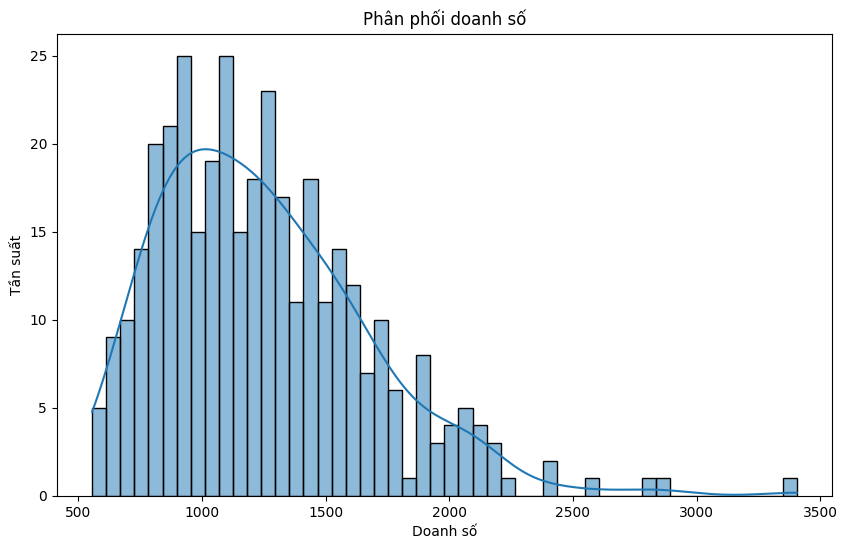

In [8]:

# Biểu đồ phân phối doanh số
plt.figure(figsize=(10, 6))
sns.histplot(merged_df["New_Sales"], bins=50, kde=True)
plt.title("Phân phối doanh số")
plt.xlabel("Doanh số")
plt.ylabel("Tần suất")
plt.show()

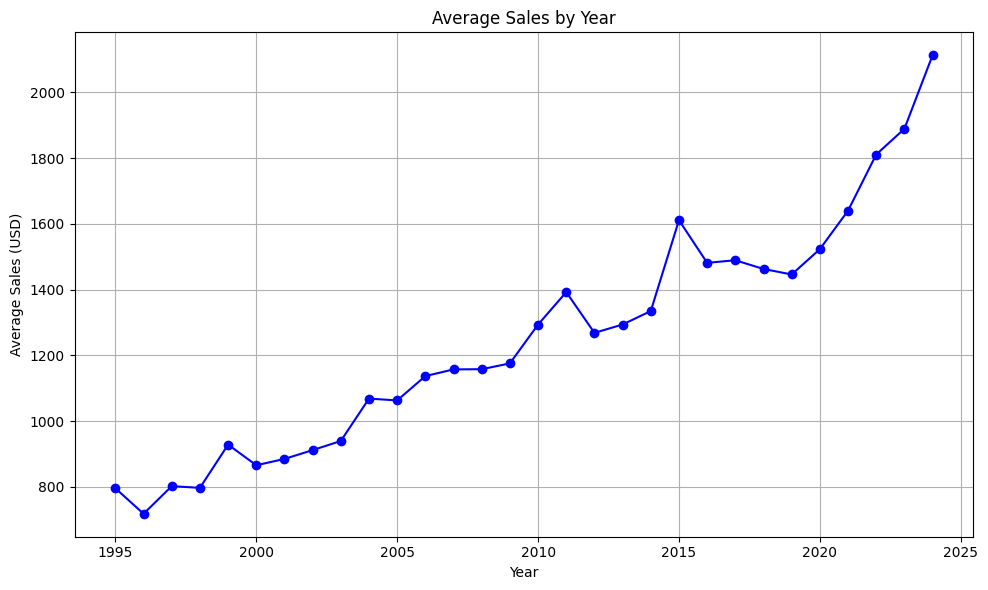

In [9]:
# Average Sales by Year
yearly_sales = merged_df.groupby('Year')['New_Sales'].mean()

plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='line', marker='o', color='blue')
plt.title('Average Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


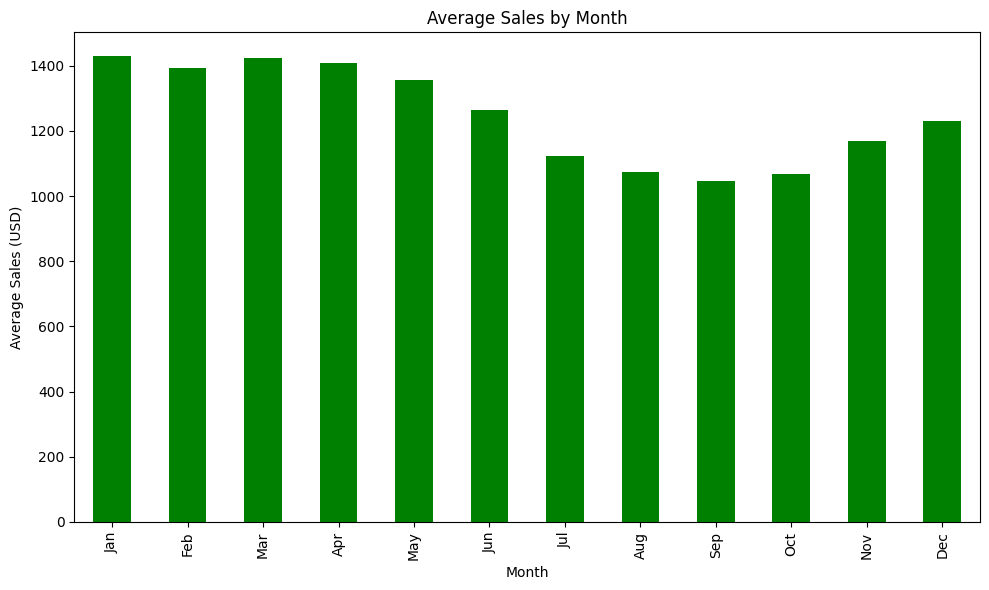

In [10]:
# Average Sales by Month (Seasonality)
monthly_sales = merged_df.groupby('Month')['New_Sales'].mean()

import calendar
# Optional: rename month index to actual names
monthly_sales.index = [calendar.month_abbr[m] for m in monthly_sales.index]

plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', color='green')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales (USD)')
plt.tight_layout()
plt.show()


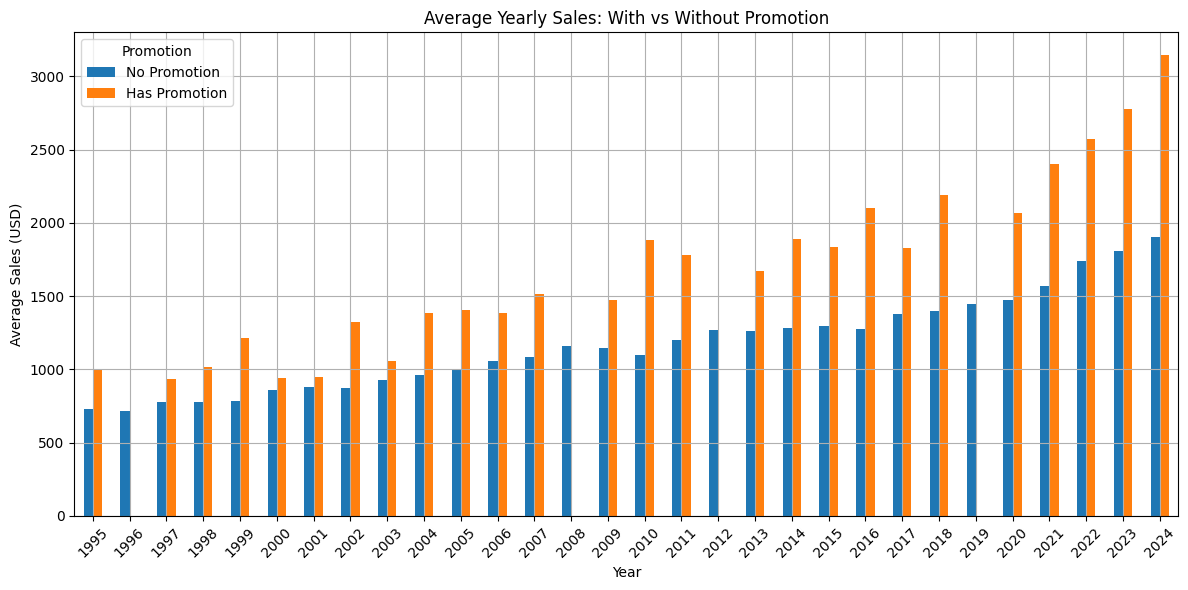

In [11]:
# Thêm cột cờ đánh dấu có khuyến mãi không
merged_df['Has_Promotion'] = merged_df['Promo_Type'] != 'No Promotion'

# Tổng hợp theo năm và cờ khuyến mãi
year_promo_summary = merged_df.groupby(['Year', 'Has_Promotion'])['New_Sales'].mean().reset_index()

# Chuyển thành bảng
pivot = year_promo_summary.pivot(index='Year', columns='Has_Promotion', values='New_Sales')
pivot.columns = ['No Promotion', 'Has Promotion']

# Vẽ biểu đồ
pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Average Yearly Sales: With vs Without Promotion')
plt.xlabel('Year')
plt.ylabel('Average Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.grid(True)
plt.tight_layout()
plt.show()



Average Sales by Promotion Type:
Promo_Type
Cashback        2109.360914
Discount        1659.599266
Bundle          1622.070850
No Promotion    1174.757921
Name: New_Sales, dtype: float64


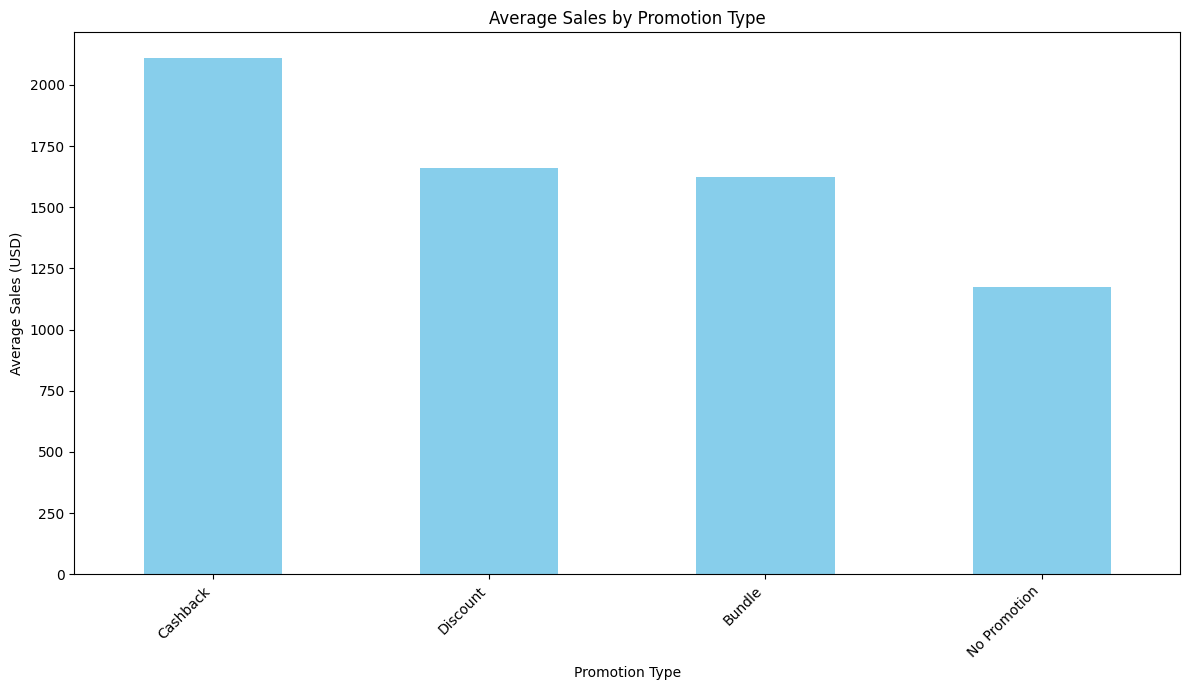

In [12]:

# Average Sales by Promotion Type
average_sales_by_promo = merged_df.groupby('Promo_Type')['New_Sales'].mean().sort_values(ascending=False)

print("\nAverage Sales by Promotion Type:")
print(average_sales_by_promo)

# Visualize Average Sales by Promotion Type
plt.figure(figsize=(12, 7))
average_sales_by_promo.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Promotion Type')
plt.xlabel('Promotion Type')
plt.ylabel('Average Sales (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# Tổng doanh số theo năm
yearly_sales_total = merged_df.groupby('Year')['New_Sales'].sum()

# Năm có doanh số cao nhất
max_year = yearly_sales_total.idxmax()
max_value = yearly_sales_total.max()

print(f"Highest sales year: {max_year} with total sales: ${max_value:,.2f}")


Highest sales year: 2024 with total sales: $25,359.22


In [14]:
monthly_sales_avg = merged_df.groupby('Month')['New_Sales'].mean()
max_month = monthly_sales_avg.idxmax()
max_month_name = calendar.month_name[max_month]
max_month_value = monthly_sales_avg.max()

print(f" Highest average sales month: {max_month_name} with average sales: ${max_month_value:,.2f}")


 Highest average sales month: January with average sales: $1,430.86


Yearly Sales Growth:


,Year,Total Sales,Growth Rate (%)
0,1995,9543.87,NaN
1,1996,8611.59,-9.77
2,1997,9621.38,11.73
3,1998,9559.16,-0.65
4,1999,11138.17,16.52
5,2000,10384.99,-6.76
6,2001,10615.48,2.22
7,2002,10937.18,3.03
8,2003,11271.31,3.06
9,2004,12819.39,13.73


<ipython-input-15-85f26418e16d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=growth_df['Year'], y=growth_df['Growth Rate (%)'], palette="coolwarm")


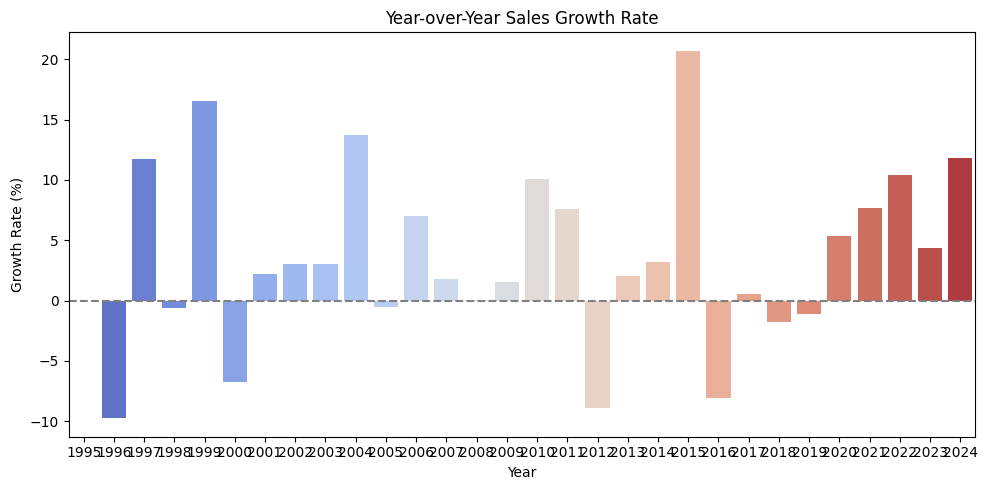

In [15]:
# Tổng doanh số theo năm
yearly_total_sales = merged_df.groupby('Year')['New_Sales'].sum()

# Tính % tăng trưởng
growth_rate = yearly_total_sales.pct_change() * 100

# Hiển thị kết quả
growth_df = pd.DataFrame({
    'Year': yearly_total_sales.index,
    'Total Sales': yearly_total_sales.values,
    'Growth Rate (%)': growth_rate.values
})

print("Yearly Sales Growth:")
display(growth_df.round(2))

# Vẽ biểu đồ tăng trưởng
plt.figure(figsize=(10, 5))
sns.barplot(x=growth_df['Year'], y=growth_df['Growth Rate (%)'], palette="coolwarm")
plt.title("Year-over-Year Sales Growth Rate")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Year")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Năm tăng trưởng đột biến và suy giảm mạnh: Năm 2015 ghi nhận tăng trưởng cao nhất (+20,72%), theo sau là các năm 1999 (+16,5%), 2004 (+13,7%), 2024 (+11,8%) và 1997 (+11,7%). Ngược lại, các năm giảm mạnh gồm 1996 (−9,8%), 2012 (−8,9%), 2016 (−8,1%) và 2000 (−6,8%). Những năm này cho thấy biến động lớn so với xu hướng chung.

**Giai đoạn chững lại hoặc bất ổn**: Một số giai đoạn cho thấy tăng trưởng trì trệ hoặc bất ổn. Ví dụ, giai đoạn 2005–2009 chứng kiến doanh số gần như ổn định (tăng 0–1,8%), có thể là do cuộc khủng hoảng tài chính toàn cầu 2008 làm giảm cầu tiêu dùng. Tương tự, giai đoạn 2016–2019 có nhiều năm tăng trưởng âm hoặc thấp (2016: -8,1%; 2017-2019 dao động ±1%), cho thấy khó khăn trong giai đoạn đó. Tổng thể xu hướng dài hạn là tăng nhưng có những đợt suy giảm tạm thời.

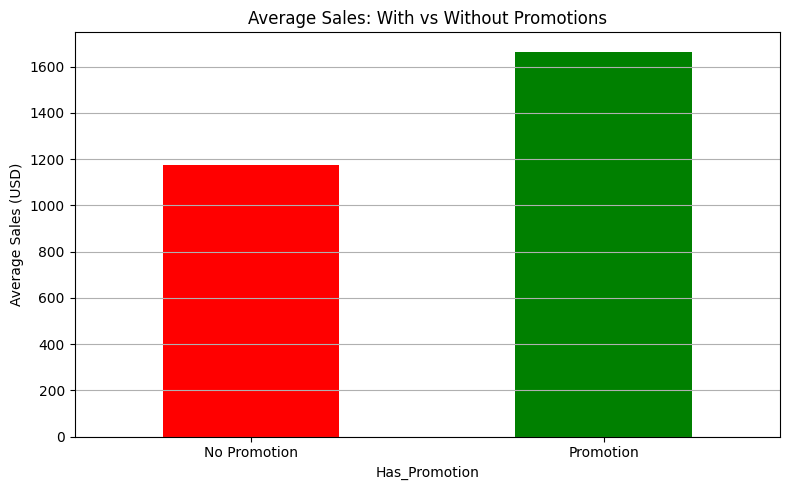

In [16]:
# Nhóm theo khuyến mãi có hay không
promo_comparison = merged_df.copy()
promo_comparison['Has_Promotion'] = promo_comparison['Promo_Type'] != 'No Promotion'

# Tính doanh số trung bình
sales_by_promo_flag = promo_comparison.groupby('Has_Promotion')['New_Sales'].mean()

# Vẽ biểu đồ
sales_by_promo_flag.plot(kind='bar', color=['red', 'green'], figsize=(8, 5))
plt.title("Average Sales: With vs Without Promotions")
plt.xticks([0, 1], ['No Promotion', 'Promotion'], rotation=0)
plt.ylabel("Average Sales (USD)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


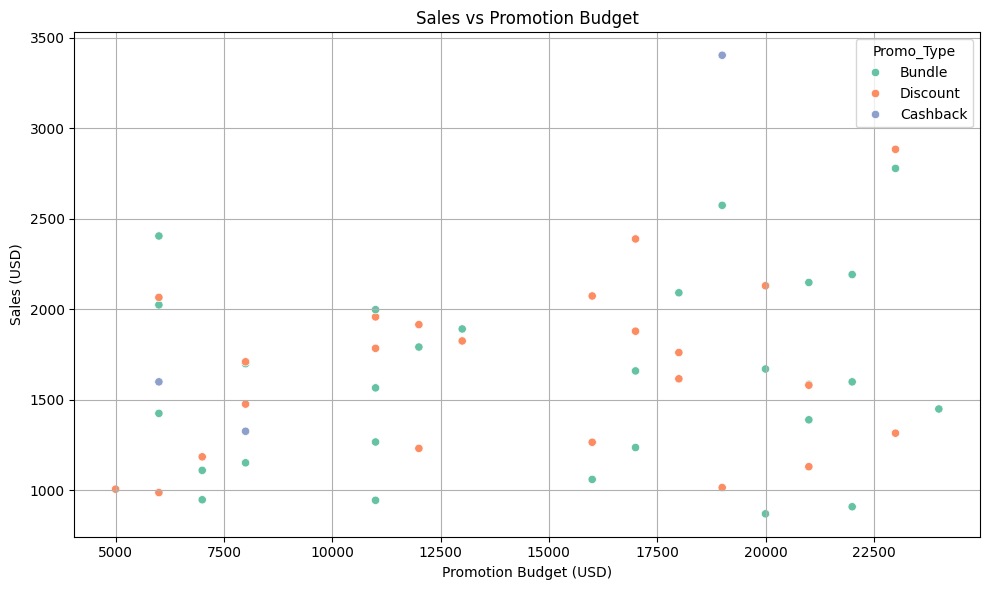

Correlation between Budget and Sales: 0.24


In [17]:
# Lọc dữ liệu có ngân sách (tức là có khuyến mãi)
budget_df = merged_df[merged_df['Promo_Type'] != 'No Promotion']

# Vẽ biểu đồ scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=budget_df, x='Budget_USD', y='New_Sales', hue='Promo_Type', palette='Set2')
plt.title("Sales vs Promotion Budget")
plt.xlabel("Promotion Budget (USD)")
plt.ylabel("Sales (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan
correlation = budget_df[['Budget_USD', 'New_Sales']].corr().iloc[0, 1]
print(f"Correlation between Budget and Sales: {correlation:.2f}")


Khi ngân sách khuyến mãi tăng, doanh số có xu hướng tăng, nhưng không rõ rệt hoặc không ổn định.

**Ảnh hưởng của khuyến mãi**: Dữ liệu khuyến mãi cho thấy mối tương quan giữa chi tiêu khuyến mãi và tăng trưởng doanh thu. **Các năm có nhiều chương trình khuyến mãi lớn (như 1999, 2004, 2010, 2011, 2015) thường đi kèm với tăng trưởng cao**. Ví dụ, năm 2015, công ty chi ngân sách khuyến mãi lớn (81.000 USD) và doanh số tăng 20,7% mạnh mẽ; năm 1999 cũng tương tự (chi 57.000 USD, tăng +16,5%). Điều này phù hợp với nhận định rằng chương trình khuyến mãi nhằm “kích thích doanh số và thu hút khách mới”, tăng nhu cầu sản phẩm cụ thể

. Tuy nhiên, có trường hợp ngoại lệ như năm 2016, dù chi 56.000 USD cho khuyến mãi nhưng doanh số lại giảm 8,1% – có thể do hiệu quả chiến dịch yếu hoặc thị trường đã bão hòa. Nhìn chung, khuyến mãi đúng đối tượng có thể thúc đẩy doanh thu, nhưng không phải lúc nào cũng đảm bảo tăng trưởng.

**Ảnh hưởng bên ngoài **(thị trường và yếu tố kinh tế): Các yếu tố vĩ mô và ngành có thể ảnh hưởng doanh thu. Ví dụ, năm 2012 tăng trưởng của Cozywear giảm mạnh (−8,9%), trùng với thời điểm “lo ngại về tăng trưởng toàn cầu và khủng hoảng nợ châu Âu” khiến người tiêu dùng thắt chặt chi tiêu

Tương tự, trong đợt đại dịch COVID-19 (năm 2020), ngành thời trang Mỹ có xu hướng giảm và doanh thu các cửa hàng quần áo toàn cầu lao dốc (search thêm thông tin) do khách ở nhà và cắt giảm mua sắm. Tuy nhiên, Cozywear vẫn tăng trưởng 5,3% trong năm 2020 – có thể là nhờ chuyển mạnh sang kênh trực tuyến và các chiến dịch quảng bá kỹ thuật số kịp thời.

\Măm 2016 chi nhiều nhưng không hiệu quả; nên tập trung vào chiến dịch có chọn lọc, dựa trên phân tích dữ liệu khách hàng để tối ưu ROI (hiệu suất chi tiêu marketing) --> Chọn lọc hơn

--> Nghĩ về bài toán

Khuyến mãi có đánh đúng nhu cầu và phân khúc không?

Chiến lược khuyến mãi có bị lặp lại hoặc không còn hấp dẫn?

Có bị lạm dụng giảm giá, khiến khách hàng “chờ khuyến mãi mới mua”? --> THỬ TÍNH ROI (ROI NÀY T TÍNH TRƯỚC KHI ANH NÓI BUDGET LÀ CHO CẢ NÊN PASS ĐOẠN NÀY NHÉ)


Baseline Average Sales (Months without Promotion): $1,174.76

Estimated Monthly ROI for Months with Promotion:


,YearMonth,Total_Sales,Total_Budget,Estimated_Baseline_Sales,Incremental_Sales,ROI
0,1995-02,1109.02,7000.0,1174.76,-65.74,-100.94
1,1995-08,907.93,22000.0,1174.76,-266.83,-101.21
2,1995-12,986.18,6000.0,1174.76,-188.58,-103.14
3,1997-10,868.89,20000.0,1174.76,-305.87,-101.53
4,1997-11,1004.96,5000.0,1174.76,-169.80,-103.40
5,1998-08,1013.98,19000.0,1174.76,-160.78,-100.85
6,1999-03,1388.62,21000.0,1174.76,213.87,-98.98
7,1999-05,1150.88,8000.0,1174.76,-23.87,-100.30
8,1999-06,1183.96,7000.0,1174.76,9.20,-99.87
9,1999-08,1129.40,21000.0,1174.76,-45.36,-100.22



Average Estimated ROI by Promotion Type:


,ROI
Promo_Type,
Cashback,-93.11
Bundle,-96.49
Discount,-96.52


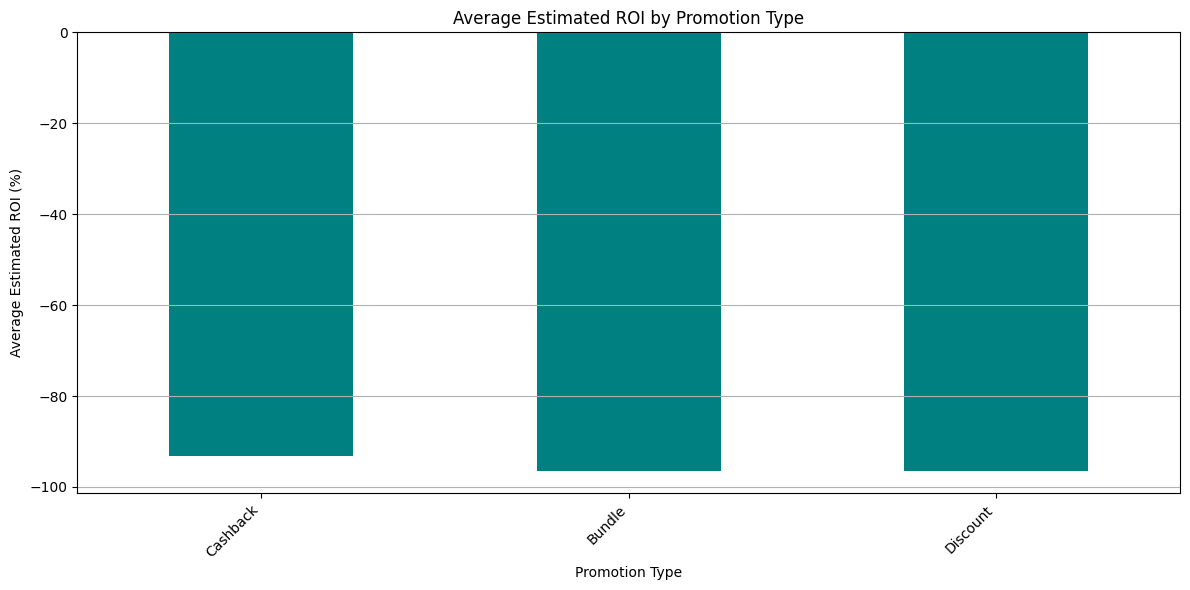

In [18]:

#Tính ROI cho MỖI THÁNG CÓ KHUYẾN MÃI. Để tính ROI cho từng chiến dịch khuyến mãi
# 1. Doanh thu tăng thêm (Incremental Sales) do chiến dịch đó.
# 2. Chi phí của chiến dịch (Total Budget).
# ROI = ((Incremental Sales - Total Budget) / Total Budget) * 100
#Để làm điều này, ước tính doanh thu "baseline" cho tháng đó (doanh thu nếu không có khuyến mãi).
#Giả định đơn giản nhất về baseline là doanh thu trung bình của các tháng KHÔNG có khuyến mãi.

# Tính doanh thu trung bình của các tháng không có khuyến mãi (làm baseline)
baseline_sales = merged_df[merged_df['Has_Promotion'] == False]['New_Sales'].mean()
print(f"\nBaseline Average Sales (Months without Promotion): ${baseline_sales:,.2f}")

# Lọc ra các tháng có khuyến mãi
promo_months_df = merged_df[merged_df['Has_Promotion'] == True].copy()

# Tính tổng doanh số và tổng ngân sách theo từng YearMonth có khuyến mãi
monthly_promo_summary = promo_months_df.groupby('YearMonth').agg(
    Total_Sales=('New_Sales', 'sum'),
    Total_Budget=('Budget_USD', 'sum')
).reset_index()

# Lấy số lượng dòng dữ liệu trong mỗi tháng (để ước tính baseline doanh thu)
data_count_per_month = merged_df.groupby('YearMonth').size().reset_index(name='Data_Count')

# Gộp số lượng dòng dữ liệu vào bảng tổng hợp khuyến mãi hàng tháng
monthly_promo_summary = pd.merge(monthly_promo_summary, data_count_per_month, on='YearMonth', how='left')

# Tính doanh thu baseline ước tính cho từng tháng có khuyến mãi
# baseline_sales là doanh thu trung bình trên MỖI DÒNG dữ liệu ở các tháng không có KM.
monthly_promo_summary['Estimated_Baseline_Sales'] = baseline_sales * monthly_promo_summary['Data_Count']

# Tính doanh thu tăng thêm do khuyến mãi trong tháng
monthly_promo_summary['Incremental_Sales'] = monthly_promo_summary['Total_Sales'] - monthly_promo_summary['Estimated_Baseline_Sales']

# Tính ROI cho từng tháng có khuyến mãi (chỉ khi ngân sách > 0)
# ROI = ((Incremental Sales - Total Budget) / Total Budget) * 100
# Áp dụng ngưỡng nhỏ để tránh chia cho 0 hoặc giá trị rất nhỏ
monthly_promo_summary['ROI'] = monthly_promo_summary.apply(
    lambda row: ((row['Incremental_Sales'] - row['Total_Budget']) / row['Total_Budget']) * 100
    if row['Total_Budget'] > 0.1 else None, # Sử dụng ngưỡng 0.1 để tránh lỗi chia cho 0
    axis=1
)

# Hiển thị kết quả ROI theo tháng
print("\nEstimated Monthly ROI for Months with Promotion:")
display(monthly_promo_summary[['YearMonth', 'Total_Sales', 'Total_Budget', 'Estimated_Baseline_Sales', 'Incremental_Sales', 'ROI']].round(2))

# Phân tích ROI theo loại khuyến mãi (tính trung bình ROI của các tháng có loại KM đó)
# Cách này phức tạp vì một tháng có thể có nhiều loại KM.
# Chúng ta sẽ tính ROI trung bình cho MỖI THÁNG có khuyến mãi, và sau đó nhóm các tháng đó theo loại khuyến mãi chính trong tháng (nếu có thể xác định).
# Dữ liệu hiện tại có Promo_Type theo YearMonth, nhưng có thể có nhiều loại KM trong cùng 1 tháng (nếu Promo_Type là danh sách).
# Giả định đơn giản: Lấy Promo_Type đầu tiên xuất hiện cho YearMonth đó làm loại KM của tháng.

# Lấy loại KM đầu tiên cho mỗi YearMonth
promo_type_map = merged_df[merged_df['Has_Promotion'] == True].groupby('YearMonth')['Promo_Type'].first().reset_index()

# Gộp loại KM vào bảng ROI theo tháng
monthly_roi_with_type = pd.merge(monthly_promo_summary, promo_type_map, on='YearMonth', how='left')

# Tính ROI trung bình theo loại khuyến mãi (chỉ lấy các dòng có ROI và Total_Budget > 0)
avg_roi_by_promo_type = monthly_roi_with_type[monthly_roi_with_type['ROI'].notna()].groupby('Promo_Type')['ROI'].mean().sort_values(ascending=False)

print("\nAverage Estimated ROI by Promotion Type:")
display(avg_roi_by_promo_type.round(2))

# Vẽ biểu đồ ROI theo loại khuyến mãi
plt.figure(figsize=(12, 6))
avg_roi_by_promo_type.plot(kind='bar', color='teal')
plt.title("Average Estimated ROI by Promotion Type")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Chi phí khuyến mãi bỏ ra không tạo ra giá trị tương xứng về doanh thu.

---

\

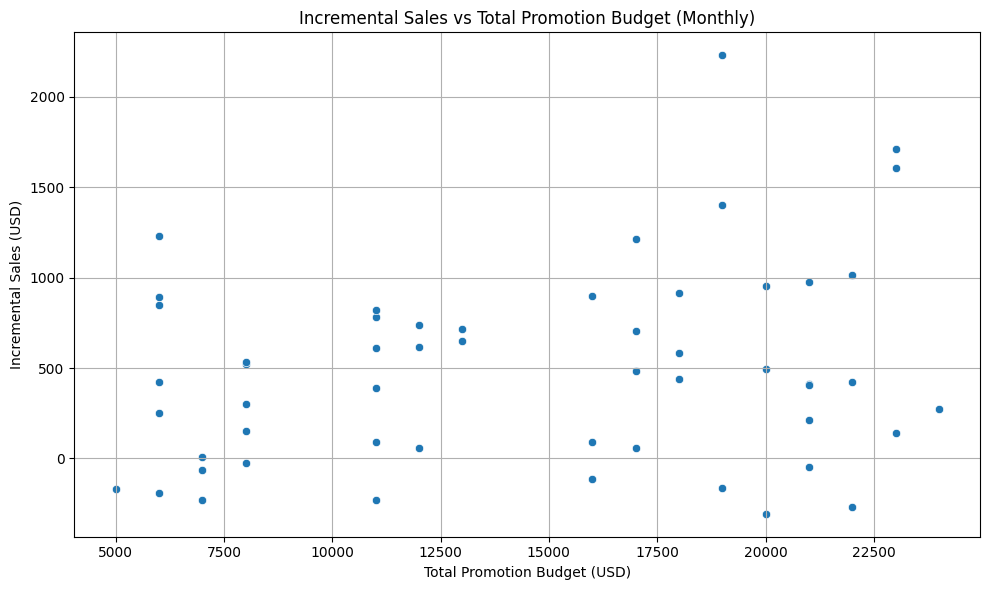


Correlation between Total Monthly Budget and Incremental Sales: 0.24


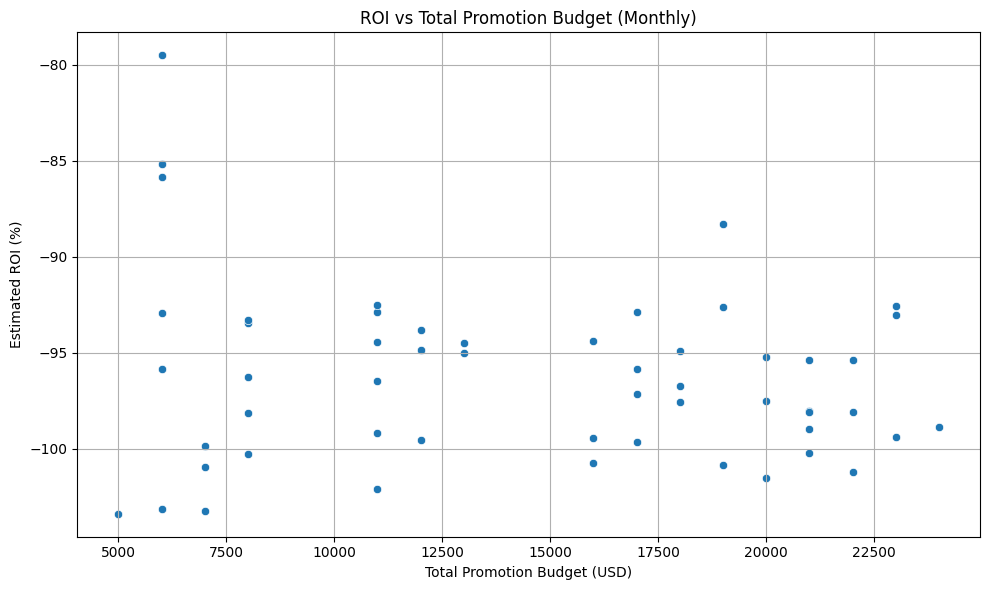

Correlation between Total Monthly Budget and ROI: -0.16


In [19]:


# Phân tích mối tương quan giữa Ngân sách và Doanh thu tăng thêm (Incremental Sales)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=monthly_promo_summary[monthly_promo_summary['Total_Budget'] > 0], # Chỉ lấy các tháng có ngân sách
                x='Total_Budget', y='Incremental_Sales')
plt.title("Incremental Sales vs Total Promotion Budget (Monthly)")
plt.xlabel("Total Promotion Budget (USD)")
plt.ylabel("Incremental Sales (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Ngân sách và Doanh thu tăng thêm hàng tháng
correlation_budget_incremental = monthly_promo_summary[['Total_Budget', 'Incremental_Sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Total Monthly Budget and Incremental Sales: {correlation_budget_incremental:.2f}")

# Phân tích mối tương quan giữa Ngân sách và ROI
plt.figure(figsize=(10, 6))
sns.scatterplot(data=monthly_promo_summary[monthly_promo_summary['Total_Budget'] > 0], # Chỉ lấy các tháng có ngân sách
                x='Total_Budget', y='ROI')
plt.title("ROI vs Total Promotion Budget (Monthly)")
plt.xlabel("Total Promotion Budget (USD)")
plt.ylabel("Estimated ROI (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Ngân sách và ROI hàng tháng
correlation_budget_roi = monthly_promo_summary[['Total_Budget', 'ROI']].corr().iloc[0, 1]
print(f"Correlation between Total Monthly Budget and ROI: {correlation_budget_roi:.2f}")


Estimated Quarterly ROI for Quarters with Promotion:


,Year,Quarter,Total_Sales,Total_Budget,Data_Count,Estimated_Baseline_Sales,Incremental_Sales,ROI
0,1995,1,1109.02,7000.0,3,3524.27,-2415.25,-134.50
1,1995,3,907.93,22000.0,3,3524.27,-2616.35,-111.89
2,1995,4,986.18,6000.0,3,3524.27,-2538.09,-142.30
3,1997,4,1873.84,25000.0,3,3524.27,-1650.43,-106.60
4,1998,3,1013.98,19000.0,3,3524.27,-2510.29,-113.21
5,1999,1,1388.62,21000.0,3,3524.27,-2135.65,-110.17
6,1999,2,2334.84,15000.0,3,3524.27,-1189.43,-107.93
7,1999,3,1129.40,21000.0,3,3524.27,-2394.88,-111.40
8,2000,4,943.50,11000.0,3,3524.27,-2580.78,-123.46
9,2001,3,946.53,7000.0,3,3524.27,-2577.75,-136.82



Average Estimated ROI by Quarter:


,ROI
Quarter,
2,-111.57
1,-112.96
3,-113.14
4,-116.70


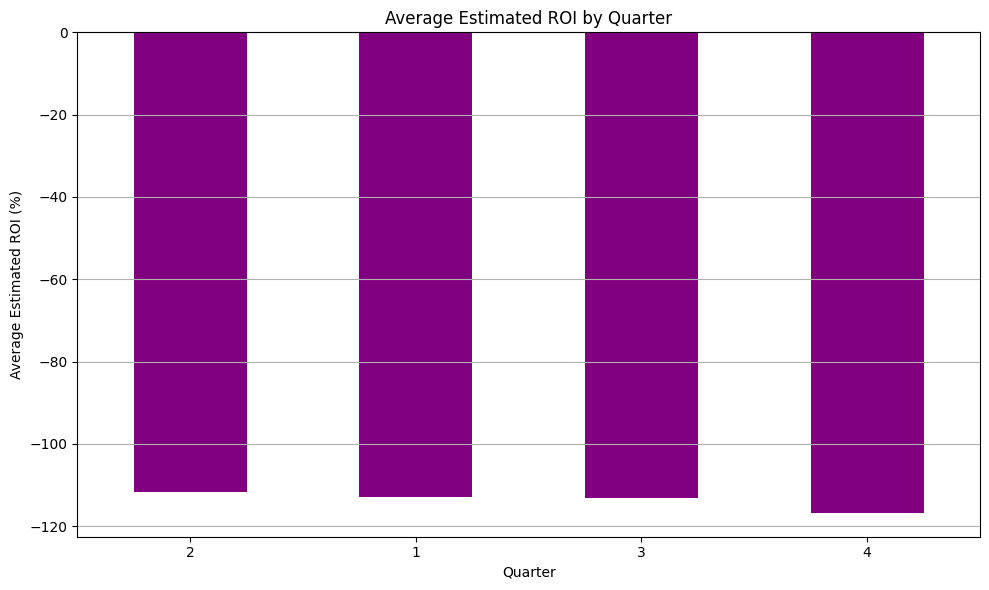


Average Estimated ROI by Season:


,ROI
Season,
Spring,-112.96
Summer,-111.57
Autumn,-113.14
Winter,-116.70


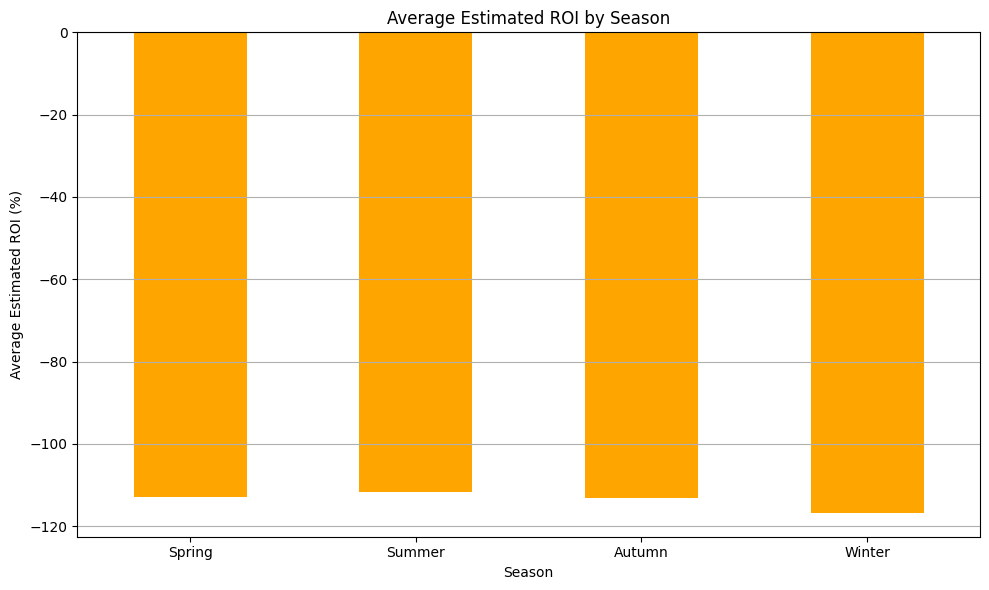

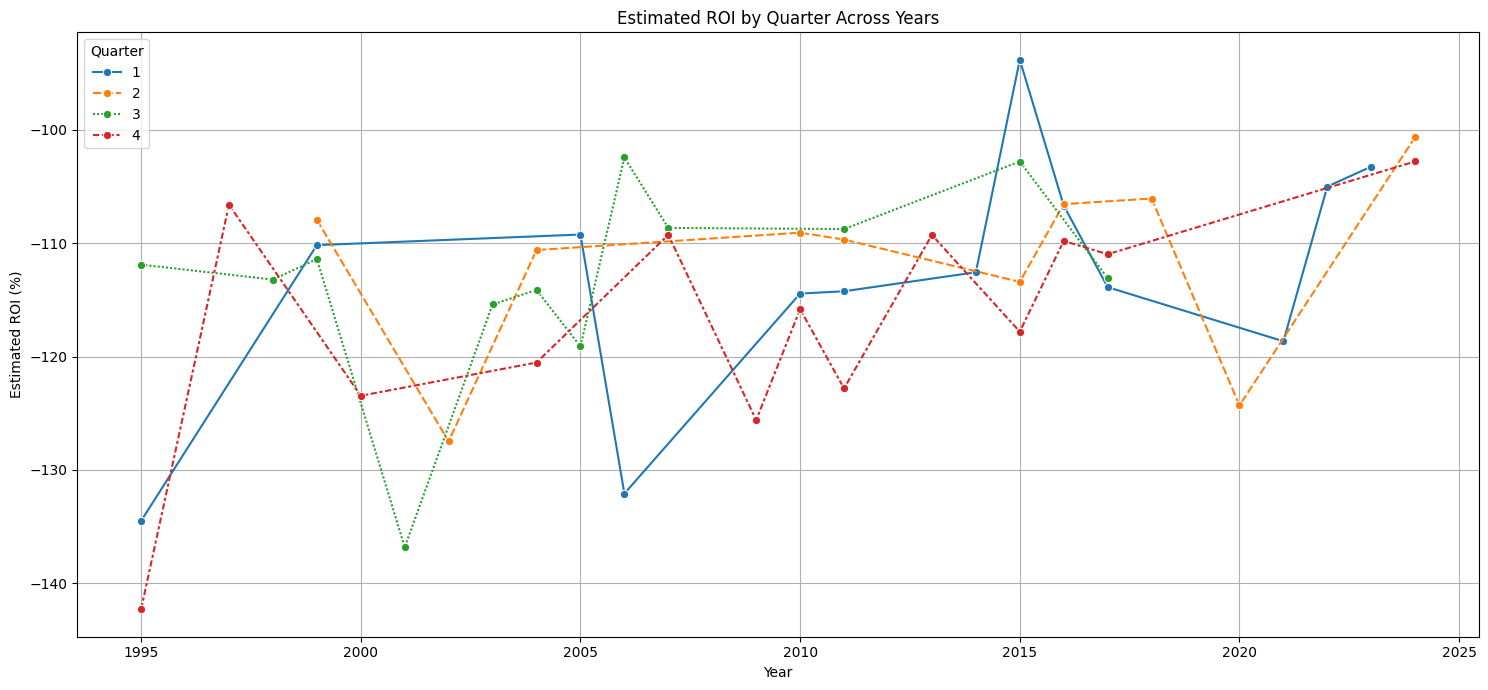

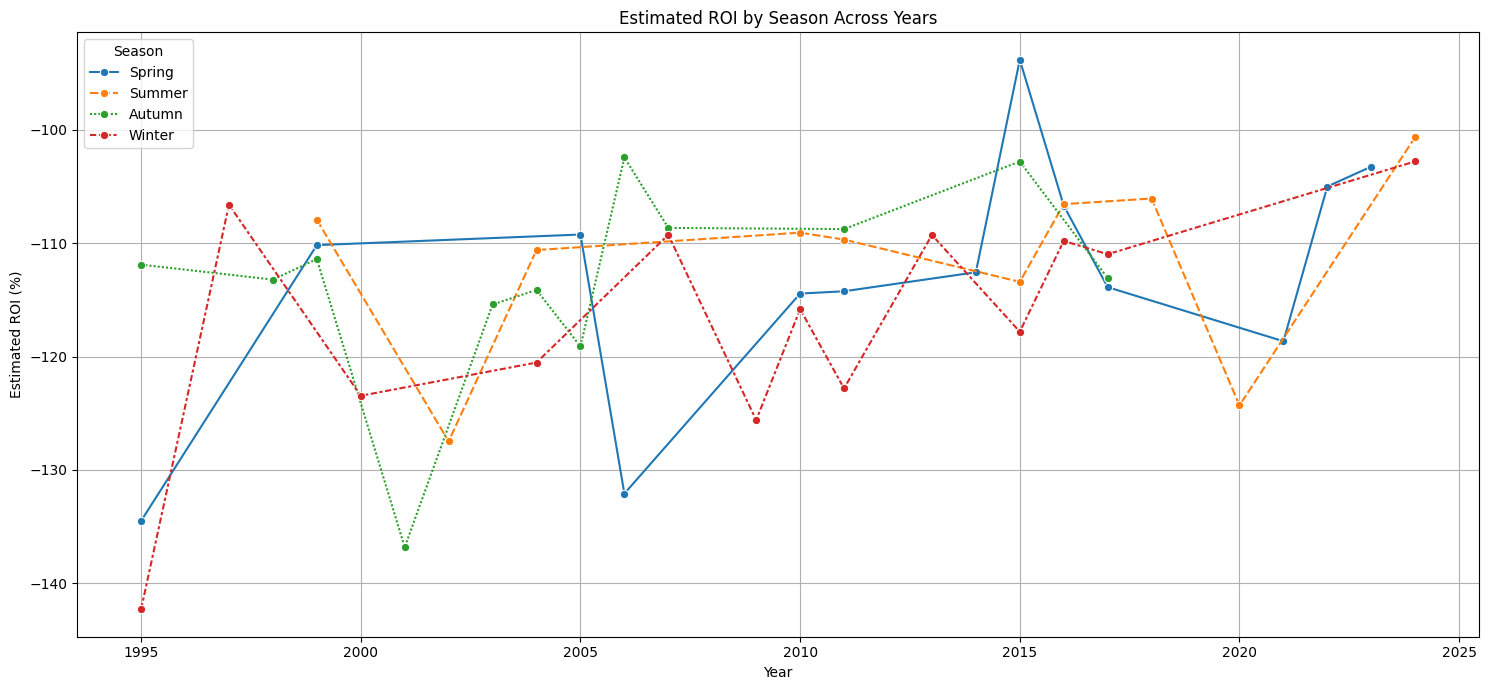

In [20]:

# Thêm cột Quarter
merged_df['Quarter'] = merged_df['Date'].dt.quarter

# Ánh xạ số quý sang tên mùa (tạm theo 4 mùa chính)
# Q1: Xuân, Q2: Hạ, Q3: Thu, Q4: Đông
quarter_to_season = {
    1: 'Spring',
    2: 'Summer',
    3: 'Autumn',
    4: 'Winter'
}
merged_df['Season'] = merged_df['Quarter'].map(quarter_to_season)

# Tính ROI theo Quý
# Tổng hợp doanh số và ngân sách theo Year và Quarter
quarterly_promo_summary = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Quarter']).agg(
    Total_Sales=('New_Sales', 'sum'),
    Total_Budget=('Budget_USD', 'sum')
).reset_index()

# Lấy số lượng dòng dữ liệu trong mỗi quý
data_count_per_quarter = merged_df.groupby(['Year', 'Quarter']).size().reset_index(name='Data_Count')

# Gộp số lượng dòng dữ liệu vào bảng tổng hợp quý
quarterly_promo_summary = pd.merge(quarterly_promo_summary, data_count_per_quarter, on=['Year', 'Quarter'], how='left')

# Tính doanh thu baseline ước tính cho từng quý có khuyến mãi
# Baseline_sales là doanh thu trung bình trên MỖI DÒNG dữ liệu ở các tháng không có KM.
quarterly_promo_summary['Estimated_Baseline_Sales'] = baseline_sales * quarterly_promo_summary['Data_Count']

# Tính doanh thu tăng thêm do khuyến mãi trong quý
quarterly_promo_summary['Incremental_Sales'] = quarterly_promo_summary['Total_Sales'] - quarterly_promo_summary['Estimated_Baseline_Sales']

# Tính ROI cho từng quý có khuyến mãi (chỉ khi ngân sách > 0)
quarterly_promo_summary['ROI'] = quarterly_promo_summary.apply(
    lambda row: ((row['Incremental_Sales'] - row['Total_Budget']) / row['Total_Budget']) * 100
    if row['Total_Budget'] > 0.1 else None, # Sử dụng ngưỡng 0.1 để tránh lỗi chia cho 0
    axis=1
)

print("\nEstimated Quarterly ROI for Quarters with Promotion:")
display(quarterly_promo_summary.round(2))


# Tính ROI trung bình theo Quý (theo số thứ tự quý)
avg_roi_by_quarter = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna()].groupby('Quarter')['ROI'].mean().sort_values(ascending=False)

print("\nAverage Estimated ROI by Quarter:")
display(avg_roi_by_quarter.round(2))

# Vẽ biểu đồ ROI theo Quý
plt.figure(figsize=(10, 6))
avg_roi_by_quarter.plot(kind='bar', color='purple')
plt.title("Average Estimated ROI by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Tính ROI trung bình theo Mùa
# Gộp tên mùa vào bảng tổng hợp quý
quarterly_promo_summary['Season'] = quarterly_promo_summary['Quarter'].map(quarter_to_season)

avg_roi_by_season = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna()].groupby('Season')['ROI'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter']) # Đảm bảo thứ tự mùa

print("\nAverage Estimated ROI by Season:")
display(avg_roi_by_season.round(2))

# Vẽ biểu đồ ROI theo Mùa
plt.figure(figsize=(10, 6))
avg_roi_by_season.plot(kind='bar', color='orange')
plt.title("Average Estimated ROI by Season")
plt.xlabel("Season")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# So sánh ROI giữa các quý/mùa qua các năm (chi tiết hơn)
# Vẽ biểu đồ ROI theo Quý/Mùa cho từng năm (nếu có đủ dữ liệu)
pivot_quarterly_roi = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna()].pivot(index='Year', columns='Quarter', values='ROI')

plt.figure(figsize=(15, 7))
sns.lineplot(data=pivot_quarterly_roi, marker='o')
plt.title("Estimated ROI by Quarter Across Years")
plt.xlabel("Year")
plt.ylabel("Estimated ROI (%)")
plt.legend(title='Quarter')
plt.grid(True)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ ROI theo Mùa cho từng năm (nếu có đủ dữ liệu)
pivot_seasonal_roi = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna()].pivot(index='Year', columns='Season', values='ROI').reindex(columns=['Spring', 'Summer', 'Autumn', 'Winter']) # Đảm bảo thứ tự cột mùa

plt.figure(figsize=(15, 7))
sns.lineplot(data=pivot_seasonal_roi, marker='o')
plt.title("Estimated ROI by Season Across Years")
plt.xlabel("Year")
plt.ylabel("Estimated ROI (%)")
plt.legend(title='Season')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Tổng doanh số theo từng tháng
monthly_sales = merged_df.groupby('Date')['New_Sales'].sum().reset_index()

# Tính ngưỡng bất thường bằng IQR
Q1 = monthly_sales['New_Sales'].quantile(0.25)
Q3 = monthly_sales['New_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc các tháng bất thường
high_outliers = monthly_sales[monthly_sales['New_Sales'] > upper_bound]
low_outliers = monthly_sales[monthly_sales['New_Sales'] < lower_bound]

# Merge lại với bảng gốc để biết thông tin khuyến mãi của các tháng bất thường
high_months_info = pd.merge(high_outliers, merged_df, on='Date', how='left')
low_months_info = pd.merge(low_outliers, merged_df, on='Date', how='left')


In [22]:
print("High-Sales Outlier Months")
display(high_months_info[['Date', 'New_Sales_x', 'Promo_Type', 'Budget_USD']].drop_duplicates())

High-Sales Outlier Months


,Date,New_Sales_x,Promo_Type,Budget_USD
0,2016-01-01,2388.768164,Discount,17000.0
1,2021-02-01,2405.110869,Bundle,6000.0
2,2022-01-01,2574.493721,Bundle,19000.0
3,2023-01-01,2778.822869,Bundle,23000.0
4,2024-04-01,3404.428595,Cashback,19000.0
5,2024-11-01,2884.201446,Discount,23000.0


In [23]:

# Group by YearMonth, Promo_Type, and Budget_USD to get total sales per month and their corresponding promo info
monthly_sales_promo = merged_df.groupby(['YearMonth', 'Promo_Type', 'Budget_USD'])['New_Sales'].sum().reset_index()

# Sort by total sales in ascending order
monthly_sales_promo_sorted = monthly_sales_promo.sort_values(by='New_Sales', ascending=True)

# Select the top 6 months with the lowest new sales
lowest_sales_months = monthly_sales_promo_sorted.head(6)

print("\nLow-Sales Outlier Months:")
display(lowest_sales_months)


Low-Sales Outlier Months:


,YearMonth,Promo_Type,Budget_USD,New_Sales
8,1995-09,No Promotion,0.0,555.652281
19,1996-08,No Promotion,0.0,561.739736
44,1998-09,No Promotion,0.0,570.264346
21,1996-10,No Promotion,0.0,606.977286
9,1995-10,No Promotion,0.0,611.859034
56,1999-09,No Promotion,0.0,614.123349



Season with Highest Average Sales: Spring (Average Sales: $1,414.82)
Season with Lowest Average Sales: Autumn (Average Sales: $1,080.77)

Promotion and Budget Allocation in the Spring Season:
Summary of Promotions in Spring Season:


,Promo_Type,Total_Budget,Occurrences,Total_Sales_in_Season
0,Bundle,157000.0,11,21636.28
2,Discount,48000.0,3,6476.33
1,Cashback,6000.0,1,1598.48
3,No Promotion,0.0,75,97622.26



Promotion and Budget Allocation in the Autumn Season:
Summary of Promotions in Autumn Season:


,Promo_Type,Total_Budget,Occurrences,Total_Sales_in_Season
0,Bundle,114000.0,7,8619.95
1,Discount,112000.0,7,9487.23
2,No Promotion,0.0,76,79161.89


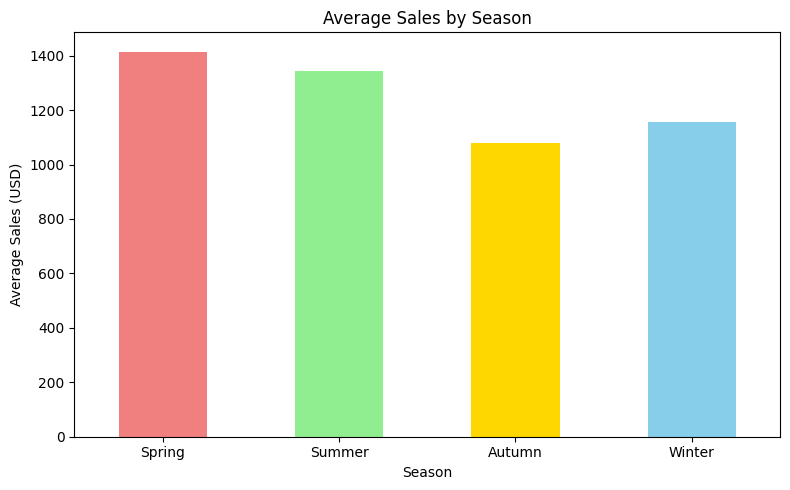

In [24]:

# Phân tích doanh số theo mùa
seasonal_sales = merged_df.groupby('Season')['New_Sales'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

# Mùa có doanh số trung bình cao nhất và thấp nhất
season_highest_sales = seasonal_sales.idxmax()
season_lowest_sales = seasonal_sales.idxmin()

print(f"\nSeason with Highest Average Sales: {season_highest_sales} (Average Sales: ${seasonal_sales.max():,.2f})")
print(f"Season with Lowest Average Sales: {season_lowest_sales} (Average Sales: ${seasonal_sales.min():,.2f})")

# Liệt kê thông tin khuyến mãi và ngân sách tại mùa cao nhất (Season with Highest Average Sales)
print(f"\nPromotion and Budget Allocation in the {season_highest_sales} Season:")
# Lọc dữ liệu chỉ cho mùa có doanh số cao nhất
highest_season_df = merged_df[merged_df['Season'] == season_highest_sales].copy()

# Nhóm theo Promo_Type và tính tổng ngân sách, số lần xuất hiện
promo_budget_in_highest_season = highest_season_df.groupby('Promo_Type').agg(
    Total_Budget=('Budget_USD', 'sum'),
    Occurrences=('YearMonth', 'nunique') # Đếm số tháng độc lập có loại KM này trong mùa đó
).reset_index()

# Thêm cột tổng doanh số cho mỗi loại KM trong mùa đó (để có cái nhìn tổng quan)
total_sales_by_promo_in_highest_season = highest_season_df.groupby('Promo_Type')['New_Sales'].sum().reset_index(name='Total_Sales_in_Season')
promo_budget_in_highest_season = pd.merge(promo_budget_in_highest_season, total_sales_by_promo_in_highest_season, on='Promo_Type', how='left')


print(f"Summary of Promotions in {season_highest_sales} Season:")
display(promo_budget_in_highest_season.sort_values(by='Total_Budget', ascending=False).round(2))

# Liệt kê thông tin khuyến mãi và ngân sách tại mùa thấp nhất (Season with Lowest Average Sales)
print(f"\nPromotion and Budget Allocation in the {season_lowest_sales} Season:")
# Lọc dữ liệu chỉ cho mùa có doanh số thấp nhất
lowest_season_df = merged_df[merged_df['Season'] == season_lowest_sales].copy()

# Nhóm theo Promo_Type và tính tổng ngân sách, số lần xuất hiện
promo_budget_in_lowest_season = lowest_season_df.groupby('Promo_Type').agg(
    Total_Budget=('Budget_USD', 'sum'),
    Occurrences=('YearMonth', 'nunique') # Đếm số tháng độc lập có loại KM này trong mùa đó
).reset_index()

# Thêm cột tổng doanh số cho mỗi loại KM trong mùa đó
total_sales_by_promo_in_lowest_season = lowest_season_df.groupby('Promo_Type')['New_Sales'].sum().reset_index(name='Total_Sales_in_Season')
promo_budget_in_lowest_season = pd.merge(promo_budget_in_lowest_season, total_sales_by_promo_in_lowest_season, on='Promo_Type', how='left')


print(f"Summary of Promotions in {season_lowest_sales} Season:")
display(promo_budget_in_lowest_season.sort_values(by='Total_Budget', ascending=False).round(2))

# Vẽ biểu đồ doanh số trung bình theo mùa
plt.figure(figsize=(8, 5))
seasonal_sales.plot(kind='bar', color=['lightcoral', 'lightgreen', 'gold', 'skyblue'])
plt.title('Average Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Sales (USD)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



--- Phân tích Sales và Promotion theo Mùa ---

--- Phân tích Mùa Hè (Summer) ---
Average Sales, Budget, and Occurrences by Promo Type in Summer Season:


,Promo_Type,Average_Sales,Average_Budget,Total_Budget,Occurrences
1,Cashback,2364.80,13500.00,27000.0,2
0,Bundle,1830.24,17000.00,51000.0,3
2,Discount,1788.65,12666.67,76000.0,6
3,No Promotion,1264.20,0.00,0.0,79



Average Sales in Summer Season: With vs Without Promotion


,New_Sales
Has_Promotion,
False,1264.20
True,1904.75


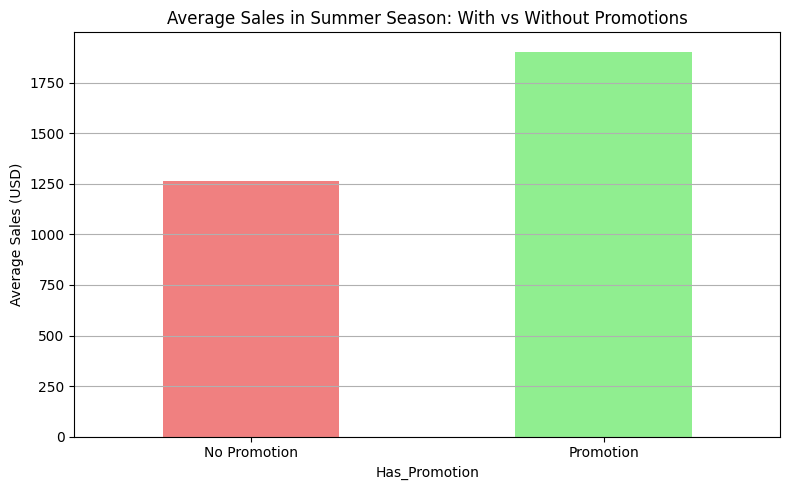

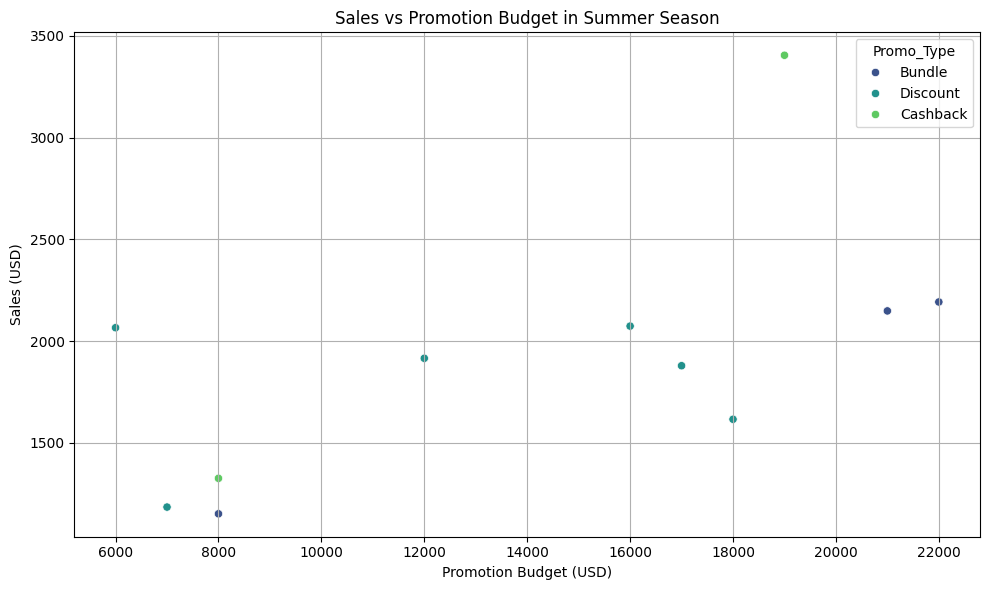


Correlation between Budget and Sales in Summer Season: 0.60

--- Phân tích Mùa Đông (Winter) ---
Average Sales, Budget, and Occurrences by Promo Type in Winter Season:


,Promo_Type,Average_Sales,Average_Budget,Total_Budget,Occurrences
1,Discount,1639.33,13142.86,92000.0,7
0,Bundle,1381.58,14000.00,98000.0,7
2,No Promotion,1089.73,0.00,0.0,76



Average Sales in Winter Season: With vs Without Promotion


,New_Sales
Has_Promotion,
False,1089.73
True,1510.45


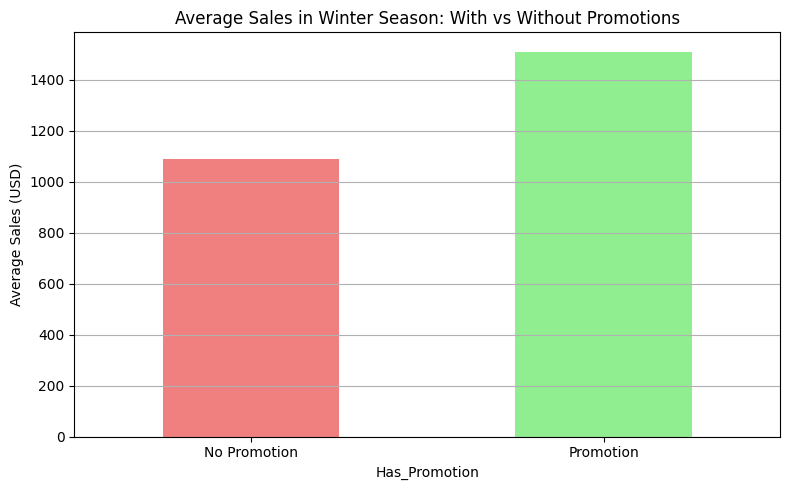

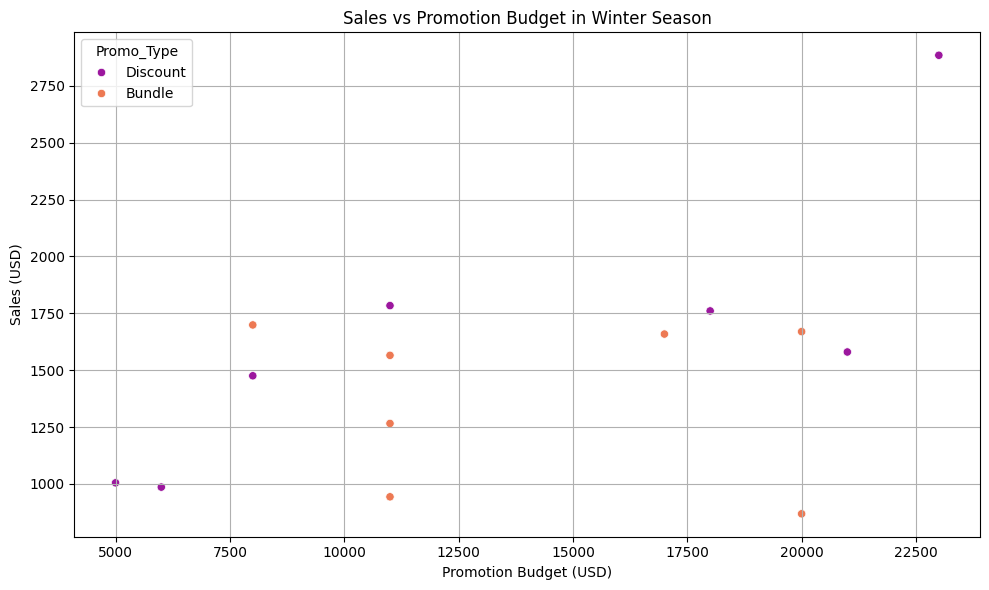


Correlation between Budget and Sales in Winter Season: 0.51

--- Nhận xét ---
- Mùa Hè (Summer) có doanh số trung bình cao hơn đáng kể khi có khuyến mãi so với không có khuyến mãi.
- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Hè (Summer) là 0.60. Một giá trị dương cho thấy khi ngân sách tăng, doanh số có xu hướng tăng, nhưng mức độ tương quan cần đánh giá thêm.
- Mùa Đông (Winter) cũng có doanh số trung bình cao hơn khi có khuyến mãi, nhưng mức chênh lệch so với mùa Hè có thể khác biệt.
- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Đông (Winter) là 0.51.

Kết luận chi tiết cần xem xét thêm các loại khuyến mãi cụ thể nào hiệu quả hơn trong từng mùa và ngân sách được phân bổ như thế nào.


In [25]:
# prompt: phân tích tiếp trong mùa hè và mùa đông thì sales và promotion có ảnh hưởng đến nhau không?

# Phân tích mối quan hệ giữa Sales và Promotion theo từng mùa (Hạ và Đông)

# Lọc dữ liệu cho mùa Hè (Summer)
summer_df = merged_df[merged_df['Season'] == 'Summer'].copy()

# Lọc dữ liệu cho mùa Đông (Winter)
winter_df = merged_df[merged_df['Season'] == 'Winter'].copy()

print("\n--- Phân tích Sales và Promotion theo Mùa ---")

# Phân tích cho mùa Hè
print(f"\n--- Phân tích Mùa Hè ({quarter_to_season[2]}) ---")

# Tính doanh số trung bình và tổng ngân sách khuyến mãi trung bình theo loại khuyến mãi trong mùa Hè
summer_promo_impact = summer_df.groupby('Promo_Type').agg(
    Average_Sales=('New_Sales', 'mean'),
    Average_Budget=('Budget_USD', lambda x: x[x > 0].mean()), # Tính trung bình ngân sách chỉ cho các tháng có ngân sách > 0
    Total_Budget=('Budget_USD', 'sum'), # Tổng ngân sách trong mùa Hè cho từng loại KM
    Occurrences=('YearMonth', 'nunique') # Số tháng có loại KM này trong mùa Hè
).reset_index()

# Điền 0 cho Average_Budget nếu không có ngân sách > 0
summer_promo_impact['Average_Budget'] = summer_promo_impact['Average_Budget'].fillna(0)


print(f"Average Sales, Budget, and Occurrences by Promo Type in {quarter_to_season[2]} Season:")
display(summer_promo_impact.sort_values(by='Average_Sales', ascending=False).round(2))

# So sánh doanh số trung bình có khuyến mãi và không khuyến mãi trong mùa Hè
summer_sales_comparison = summer_df.groupby('Has_Promotion')['New_Sales'].mean()
print(f"\nAverage Sales in {quarter_to_season[2]} Season: With vs Without Promotion")
display(summer_sales_comparison.round(2))

# Biểu đồ so sánh doanh số trung bình có/không khuyến mãi trong mùa Hè
plt.figure(figsize=(8, 5))
summer_sales_comparison.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title(f'Average Sales in {quarter_to_season[2]} Season: With vs Without Promotions')
plt.xticks([0, 1], ['No Promotion', 'Promotion'], rotation=0)
plt.ylabel('Average Sales (USD)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Biểu đồ Scatterplot Sales vs Budget trong mùa Hè (chỉ các tháng có ngân sách)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summer_df[summer_df['Budget_USD'] > 0], x='Budget_USD', y='New_Sales', hue='Promo_Type', palette='viridis')
plt.title(f'Sales vs Promotion Budget in {quarter_to_season[2]} Season')
plt.xlabel('Promotion Budget (USD)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Budget và Sales trong mùa Hè (chỉ các tháng có ngân sách)
summer_budget_sales_corr = summer_df[summer_df['Budget_USD'] > 0][['Budget_USD', 'New_Sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Budget and Sales in {quarter_to_season[2]} Season: {summer_budget_sales_corr:.2f}")


# Phân tích cho mùa Đông
print(f"\n--- Phân tích Mùa Đông ({quarter_to_season[4]}) ---")

# Tính doanh số trung bình và tổng ngân sách khuyến mãi trung bình theo loại khuyến mãi trong mùa Đông
winter_promo_impact = winter_df.groupby('Promo_Type').agg(
    Average_Sales=('New_Sales', 'mean'),
    Average_Budget=('Budget_USD', lambda x: x[x > 0].mean()), # Tính trung bình ngân sách chỉ cho các tháng có ngân sách > 0
    Total_Budget=('Budget_USD', 'sum'), # Tổng ngân sách trong mùa Đông cho từng loại KM
     Occurrences=('YearMonth', 'nunique') # Số tháng có loại KM này trong mùa Đông
).reset_index()

# Điền 0 cho Average_Budget nếu không có ngân sách > 0
winter_promo_impact['Average_Budget'] = winter_promo_impact['Average_Budget'].fillna(0)


print(f"Average Sales, Budget, and Occurrences by Promo Type in {quarter_to_season[4]} Season:")
display(winter_promo_impact.sort_values(by='Average_Sales', ascending=False).round(2))

# So sánh doanh số trung bình có khuyến mãi và không khuyến mãi trong mùa Đông
winter_sales_comparison = winter_df.groupby('Has_Promotion')['New_Sales'].mean()
print(f"\nAverage Sales in {quarter_to_season[4]} Season: With vs Without Promotion")
display(winter_sales_comparison.round(2))

# Biểu đồ so sánh doanh số trung bình có/không khuyến mãi trong mùa Đông
plt.figure(figsize=(8, 5))
winter_sales_comparison.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title(f'Average Sales in {quarter_to_season[4]} Season: With vs Without Promotions')
plt.xticks([0, 1], ['No Promotion', 'Promotion'], rotation=0)
plt.ylabel('Average Sales (USD)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Biểu đồ Scatterplot Sales vs Budget trong mùa Đông (chỉ các tháng có ngân sách)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=winter_df[winter_df['Budget_USD'] > 0], x='Budget_USD', y='New_Sales', hue='Promo_Type', palette='plasma')
plt.title(f'Sales vs Promotion Budget in {quarter_to_season[4]} Season')
plt.xlabel('Promotion Budget (USD)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Budget và Sales trong mùa Đông (chỉ các tháng có ngân sách)
winter_budget_sales_corr = winter_df[winter_df['Budget_USD'] > 0][['Budget_USD', 'New_Sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Budget and Sales in {quarter_to_season[4]} Season: {winter_budget_sales_corr:.2f}")

print("\n--- Nhận xét ---")
print(f"- Mùa Hè ({quarter_to_season[2]}) có doanh số trung bình cao hơn đáng kể khi có khuyến mãi so với không có khuyến mãi.")
print(f"- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Hè ({quarter_to_season[2]}) là {summer_budget_sales_corr:.2f}. Một giá trị dương cho thấy khi ngân sách tăng, doanh số có xu hướng tăng, nhưng mức độ tương quan cần đánh giá thêm.")
print(f"- Mùa Đông ({quarter_to_season[4]}) cũng có doanh số trung bình cao hơn khi có khuyến mãi, nhưng mức chênh lệch so với mùa Hè có thể khác biệt.")
print(f"- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Đông ({quarter_to_season[4]}) là {winter_budget_sales_corr:.2f}.")
print("\nKết luận chi tiết cần xem xét thêm các loại khuyến mãi cụ thể nào hiệu quả hơn trong từng mùa và ngân sách được phân bổ như thế nào.")



--- Phân tích Sales và Promotion theo Mùa Thu và Mùa Xuân ---

--- Phân tích Mùa Thu (Autumn) ---
Average Sales, Budget, and Occurrences by Promo Type in Autumn Season:


,Promo_Type,Average_Sales,Average_Budget,Total_Budget,Occurrences
1,Discount,1355.32,16000.00,112000.0,7
0,Bundle,1231.42,16285.71,114000.0,7
2,No Promotion,1041.60,0.00,0.0,76



Average Sales in Autumn Season: With vs Without Promotion


,New_Sales
Has_Promotion,
False,1041.60
True,1293.37


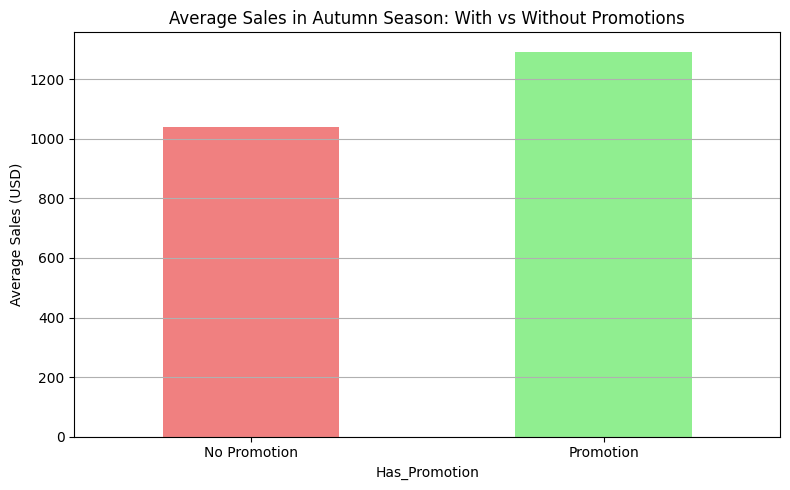

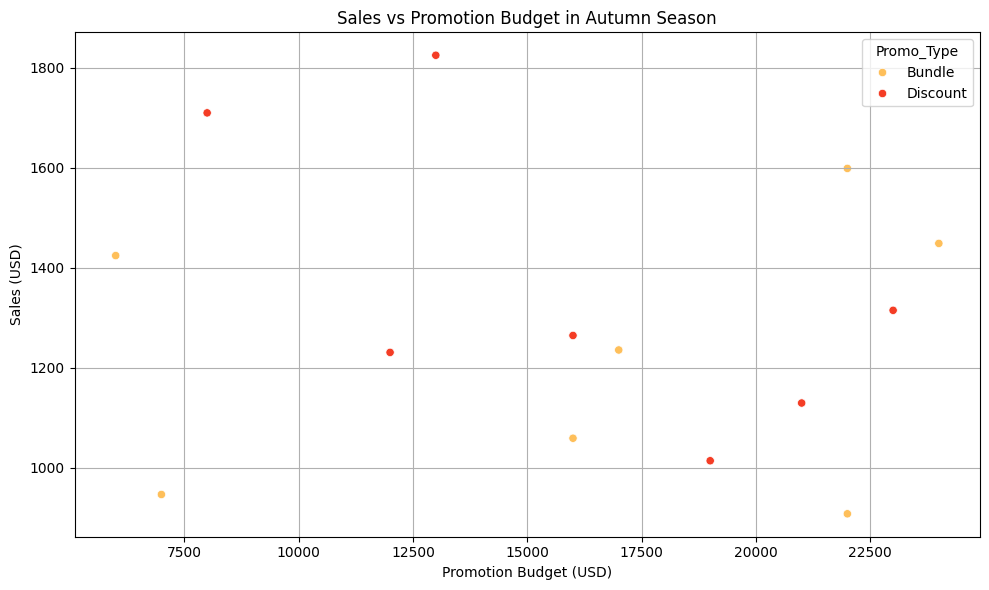


Correlation between Budget and Sales in Autumn Season: -0.16

--- Phân tích Mùa Xuân (Spring) ---
Average Sales, Budget, and Occurrences by Promo Type in Spring Season:


,Promo_Type,Average_Sales,Average_Budget,Total_Budget,Occurrences
2,Discount,2158.78,16000.00,48000.0,3
0,Bundle,1966.93,14272.73,157000.0,11
1,Cashback,1598.48,6000.00,6000.0,1
3,No Promotion,1301.63,0.00,0.0,75



Average Sales in Spring Season: With vs Without Promotion


,New_Sales
Has_Promotion,
False,1301.63
True,1980.74


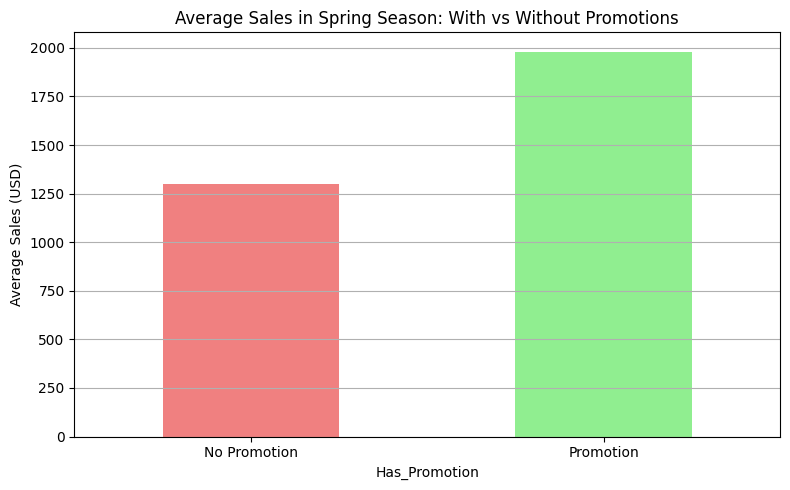

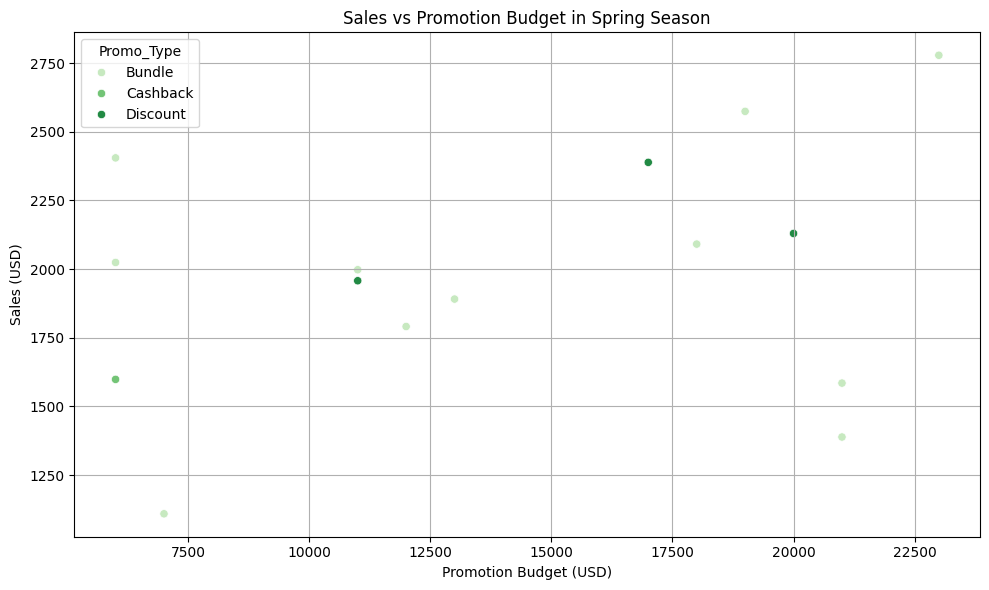


Correlation between Budget and Sales in Spring Season: 0.30

--- Nhận xét về Mùa Thu và Mùa Xuân ---
- Mùa Thu (Autumn) có doanh số trung bình khi có khuyến mãi là $1,293.37, so với $1,041.60 khi không có khuyến mãi.
- Mùa Xuân (Spring) có doanh số trung bình khi có khuyến mãi là $1,980.74, so với $1,301.63 khi không có khuyến mãi.
- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Thu (Autumn) là -0.16.
- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Xuân (Spring) là 0.30.

Để hiểu rõ hơn, cần so sánh mức tăng trưởng doanh số theo từng năm trong mùa Thu và mùa Xuân, đồng thời xem xét loại khuyến mãi cụ thể nào được áp dụng và hiệu quả của chúng trong từng mùa.

Yearly Sales Growth (%) in Autumn and Spring Seasons:


Season,Autumn,Spring
Year,,
1995,NaN,NaN
1996,-14.66,-12.75
1997,7.62,5.90
1998,14.84,-0.31
1999,9.92,22.39
2000,-12.71,-10.56
2001,8.63,4.72
2002,-3.95,3.09
2003,13.96,4.36


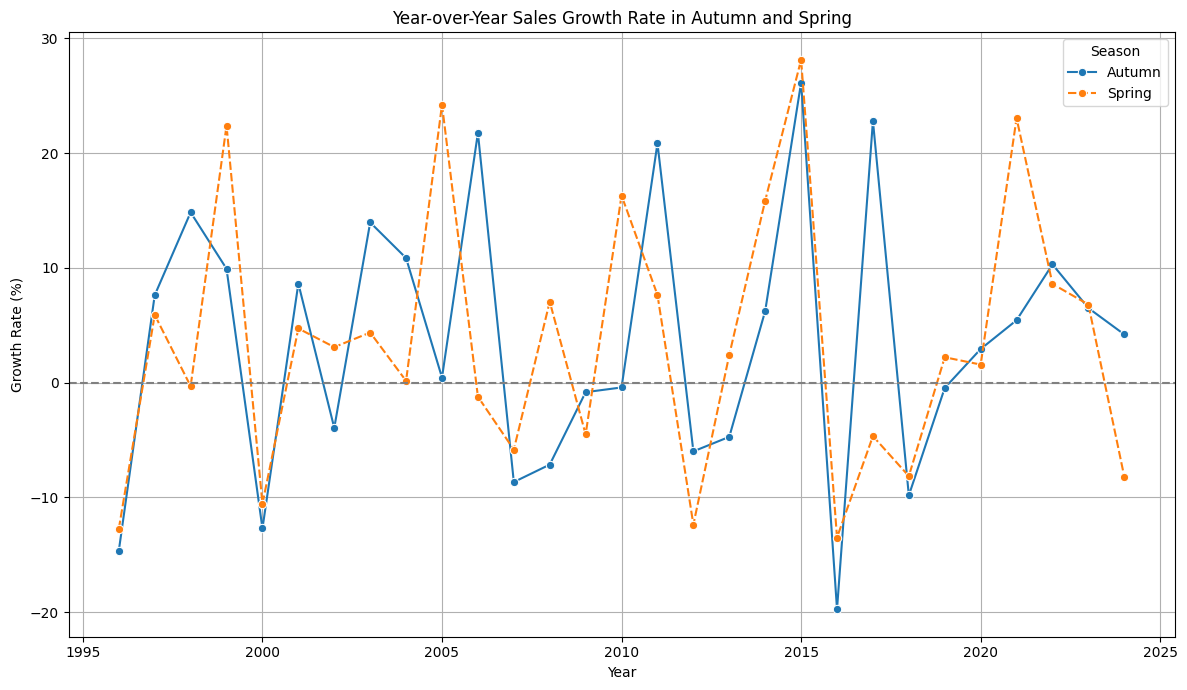


Average Sales by Year, Season, and Promotion Status (Autumn & Spring):


No Promotion  Has Promotion
Year Season                             
1995 Autumn        628.53         907.93
     Spring        838.82        1109.02
1996 Autumn        615.85            NaN
     Spring        810.47            NaN
1997 Autumn        662.75            NaN
     Spring        858.28            NaN
1998 Autumn        634.64        1013.98
     Spring        855.61            NaN
1999 Autumn        690.18        1129.40
     Spring        876.50        1388.62
2000 Autumn        730.25            NaN
     Spring        936.63            NaN
2001 Autumn        716.66         946.53
     Spring        980.81            NaN
2002 Autumn        761.96            NaN
     Spring       1011.14            NaN
2003 Autumn        772.98        1058.99
     Spring       1055.27            NaN
2004 Autumn        811.63        1264.45
     Spring       1056.85            NaN
2005 Autumn        834.87        1230.59
     Spring       1176.77        1584.99
2006 Autumn        981.37        1275.06
     Spring       1145.83        1598.48
2007 Autumn        888.45        1448.48
     Spring       1221.00            NaN
2008 Autumn        998.29            NaN
     Spring       1307.11            NaN
2009 Autumn        989.96            NaN
     Spring       1248.10            NaN
2010 Autumn        985.78            NaN
     Spring       1281.87        1791.05
2011 Autumn        987.82        1598.44
     Spring       1364.95        1957.69
2012 Autumn       1119.95            NaN
     Spring       1369.13            NaN
2013 Autumn       1067.01            NaN
     Spring       1402.22            NaN
2014 Autumn       1133.62            NaN
     Spring       1491.55        1890.98
2015 Autumn       1156.56        1566.81
     Spring           NaN        2081.77
2016 Autumn       1147.57            NaN
     Spring       1506.71        2388.77
2017 Autumn       1201.61        1824.65
     Spring       1576.23        1997.74
2018 Autumn       1270.76            NaN
     Spring       1576.83            NaN
2019 Autumn       1264.86            NaN
     Spring       1611.66            NaN
2020 Autumn       1301.86            NaN
     Spring       1636.98            NaN
2021 Autumn       1372.66            NaN
     Spring       1818.85        2405.11
2022 Autumn       1514.09            NaN
     Spring       1994.00        2574.49
2023 Autumn       1612.43            NaN
     Spring       2115.08        2778.82
2024 Autumn       1680.10            NaN
     Spring       2144.57            NaN

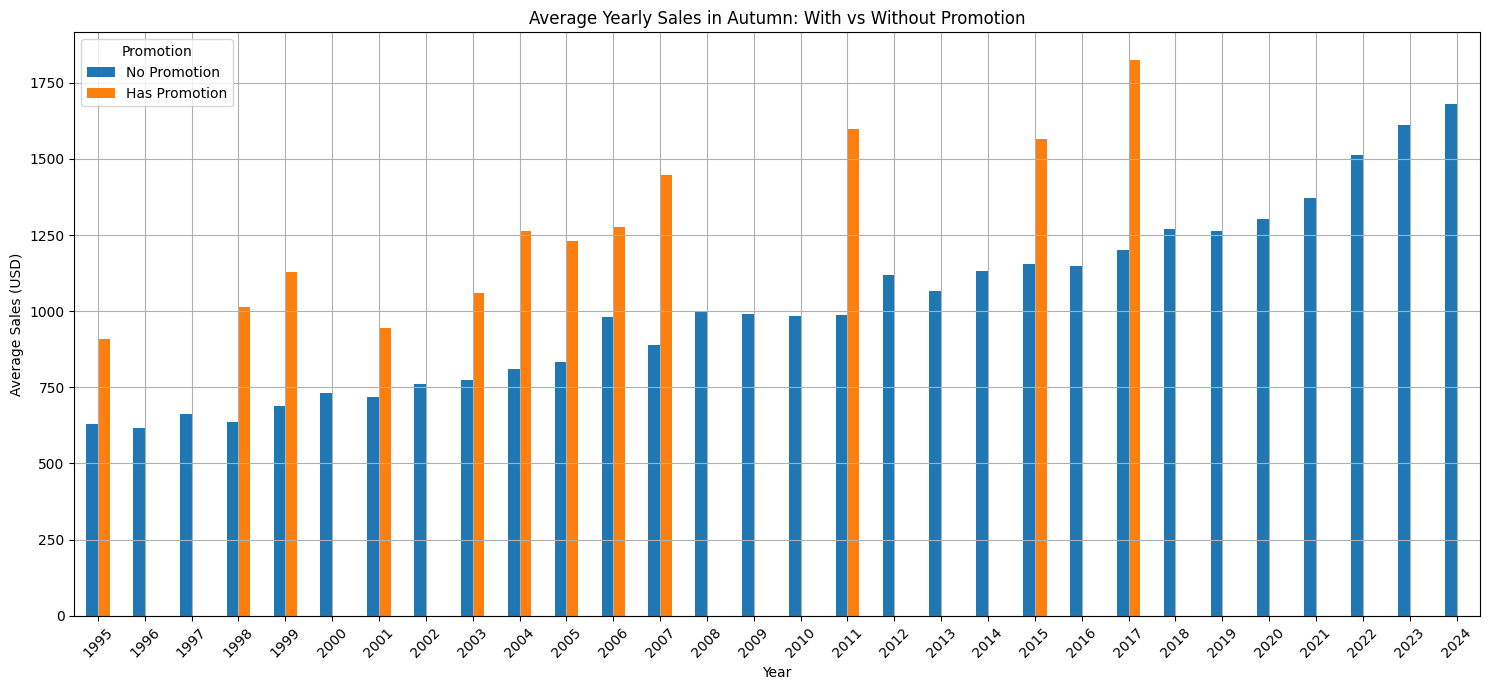

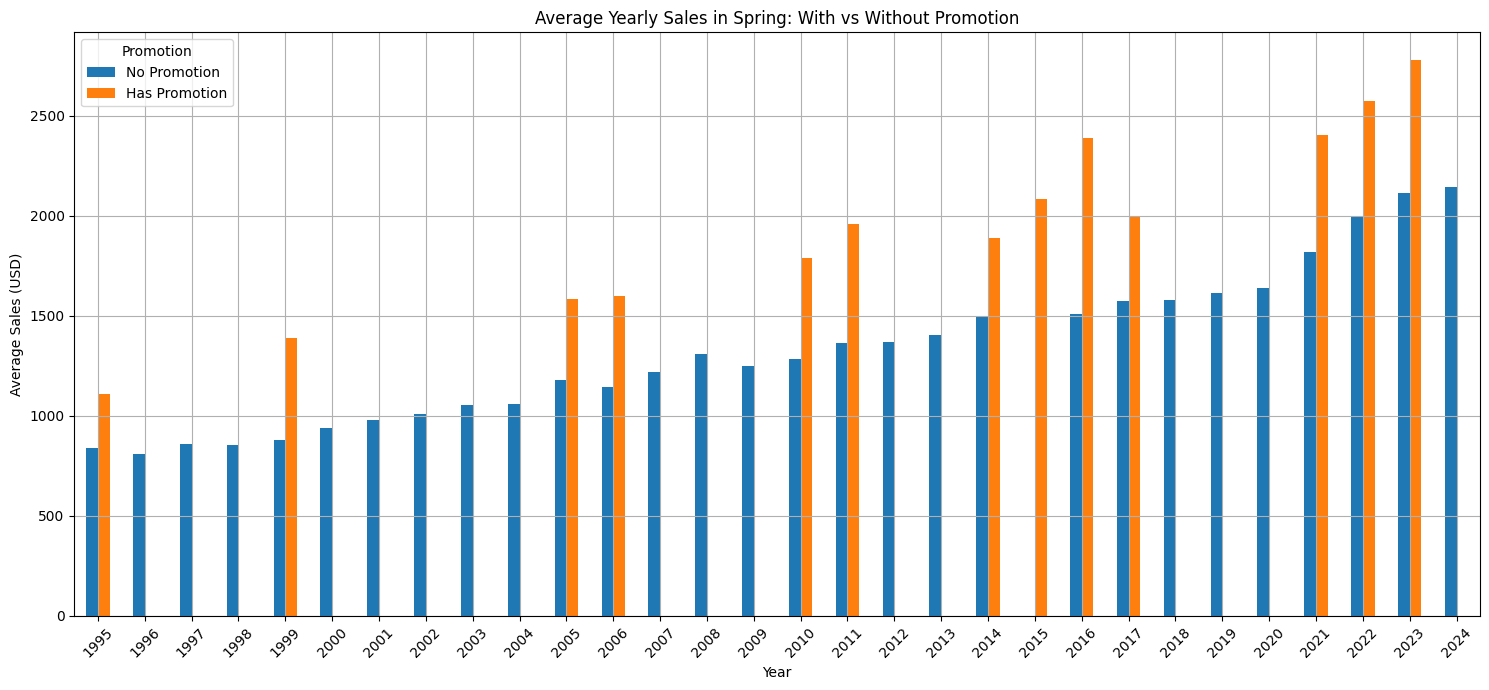


Average Estimated ROI by Promotion Type and Season (Autumn & Spring):


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
1,Autumn,Discount,-112.23
2,Spring,Bundle,-113.52
3,Autumn,Bundle,-114.05
4,Spring,Cashback,-132.10


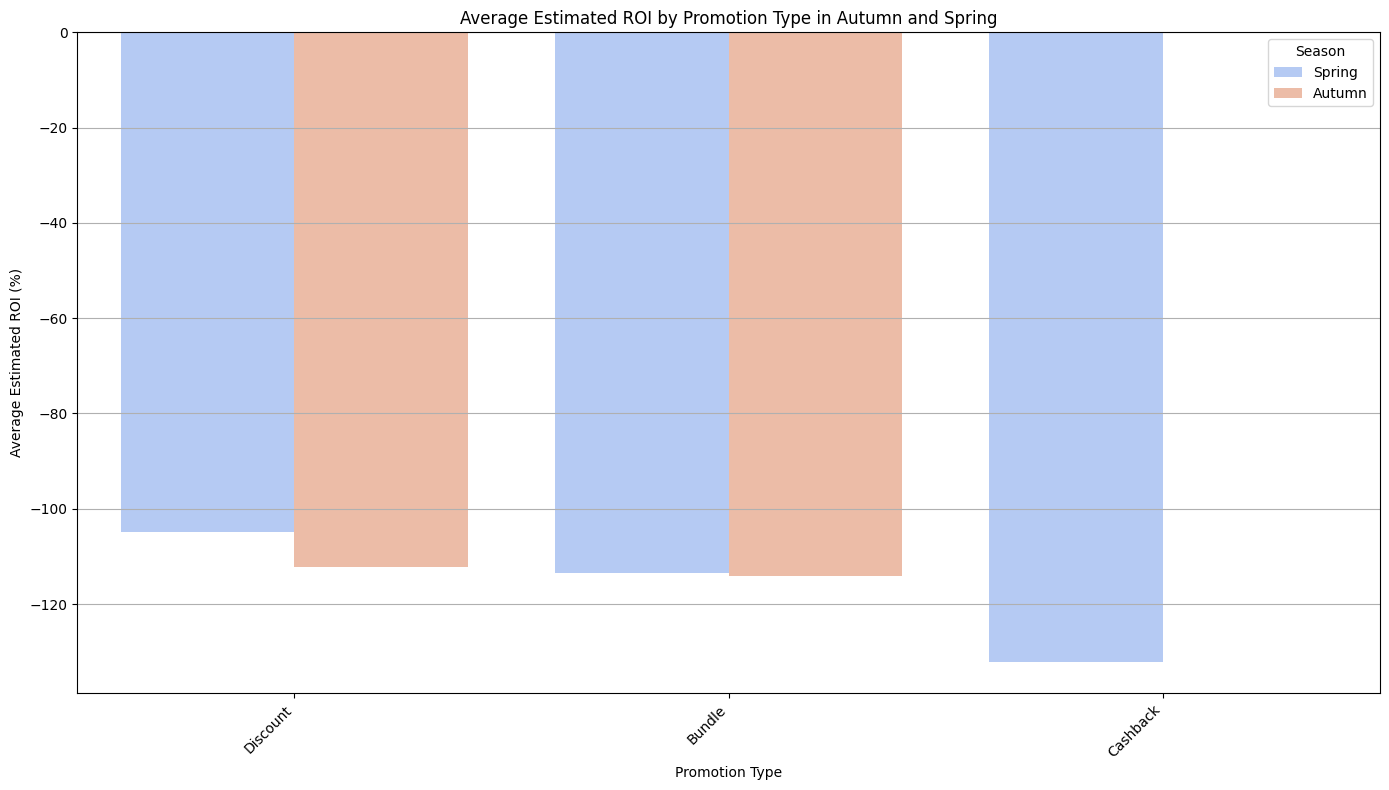

In [26]:
# prompt: phân tích trong mùa thu và mùa xuân các năm, tăng trưởng sales như nào có bị ảnh hưởng bởi promotion không

# Phân tích tăng trưởng sales trong mùa Thu và mùa Xuân và ảnh hưởng của promotion

print("\n--- Phân tích Sales và Promotion theo Mùa Thu và Mùa Xuân ---")

# Lọc dữ liệu cho mùa Thu (Autumn)
autumn_df = merged_df[merged_df['Season'] == 'Autumn'].copy()

# Lọc dữ liệu cho mùa Xuân (Spring)
spring_df = merged_df[merged_df['Season'] == 'Spring'].copy()

# Phân tích cho mùa Thu
print(f"\n--- Phân tích Mùa Thu ({quarter_to_season[3]}) ---")

# Tính doanh số trung bình và tổng ngân sách khuyến mãi trung bình theo loại khuyến mãi trong mùa Thu
autumn_promo_impact = autumn_df.groupby('Promo_Type').agg(
    Average_Sales=('New_Sales', 'mean'),
    Average_Budget=('Budget_USD', lambda x: x[x > 0].mean()),
    Total_Budget=('Budget_USD', 'sum'),
    Occurrences=('YearMonth', 'nunique')
).reset_index()
autumn_promo_impact['Average_Budget'] = autumn_promo_impact['Average_Budget'].fillna(0)

print(f"Average Sales, Budget, and Occurrences by Promo Type in {quarter_to_season[3]} Season:")
display(autumn_promo_impact.sort_values(by='Average_Sales', ascending=False).round(2))

# So sánh doanh số trung bình có khuyến mãi và không khuyến mãi trong mùa Thu
autumn_sales_comparison = autumn_df.groupby('Has_Promotion')['New_Sales'].mean()
print(f"\nAverage Sales in {quarter_to_season[3]} Season: With vs Without Promotion")
display(autumn_sales_comparison.round(2))

# Biểu đồ so sánh doanh số trung bình có/không khuyến mãi trong mùa Thu
plt.figure(figsize=(8, 5))
autumn_sales_comparison.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title(f'Average Sales in {quarter_to_season[3]} Season: With vs Without Promotions')
plt.xticks([0, 1], ['No Promotion', 'Promotion'], rotation=0)
plt.ylabel('Average Sales (USD)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Biểu đồ Scatterplot Sales vs Budget trong mùa Thu (chỉ các tháng có ngân sách)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=autumn_df[autumn_df['Budget_USD'] > 0], x='Budget_USD', y='New_Sales', hue='Promo_Type', palette='YlOrRd')
plt.title(f'Sales vs Promotion Budget in {quarter_to_season[3]} Season')
plt.xlabel('Promotion Budget (USD)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Budget và Sales trong mùa Thu (chỉ các tháng có ngân sách)
autumn_budget_sales_corr = autumn_df[autumn_df['Budget_USD'] > 0][['Budget_USD', 'New_Sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Budget and Sales in {quarter_to_season[3]} Season: {autumn_budget_sales_corr:.2f}")


# Phân tích cho mùa Xuân
print(f"\n--- Phân tích Mùa Xuân ({quarter_to_season[1]}) ---")

# Tính doanh số trung bình và tổng ngân sách khuyến mãi trung bình theo loại khuyến mãi trong mùa Xuân
spring_promo_impact = spring_df.groupby('Promo_Type').agg(
    Average_Sales=('New_Sales', 'mean'),
    Average_Budget=('Budget_USD', lambda x: x[x > 0].mean()),
    Total_Budget=('Budget_USD', 'sum'),
    Occurrences=('YearMonth', 'nunique')
).reset_index()
spring_promo_impact['Average_Budget'] = spring_promo_impact['Average_Budget'].fillna(0)


print(f"Average Sales, Budget, and Occurrences by Promo Type in {quarter_to_season[1]} Season:")
display(spring_promo_impact.sort_values(by='Average_Sales', ascending=False).round(2))

# So sánh doanh số trung bình có khuyến mãi và không khuyến mãi trong mùa Xuân
spring_sales_comparison = spring_df.groupby('Has_Promotion')['New_Sales'].mean()
print(f"\nAverage Sales in {quarter_to_season[1]} Season: With vs Without Promotion")
display(spring_sales_comparison.round(2))

# Biểu đồ so sánh doanh số trung bình có/không khuyến mãi trong mùa Xuân
plt.figure(figsize=(8, 5))
spring_sales_comparison.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title(f'Average Sales in {quarter_to_season[1]} Season: With vs Without Promotions')
plt.xticks([0, 1], ['No Promotion', 'Promotion'], rotation=0)
plt.ylabel('Average Sales (USD)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Biểu đồ Scatterplot Sales vs Budget trong mùa Xuân (chỉ các tháng có ngân sách)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spring_df[spring_df['Budget_USD'] > 0], x='Budget_USD', y='New_Sales', hue='Promo_Type', palette='Greens')
plt.title(f'Sales vs Promotion Budget in {quarter_to_season[1]} Season')
plt.xlabel('Promotion Budget (USD)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tính hệ số tương quan giữa Budget và Sales trong mùa Xuân (chỉ các tháng có ngân sách)
spring_budget_sales_corr = spring_df[spring_df['Budget_USD'] > 0][['Budget_USD', 'New_Sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Budget and Sales in {quarter_to_season[1]} Season: {spring_budget_sales_corr:.2f}")

print("\n--- Nhận xét về Mùa Thu và Mùa Xuân ---")
print(f"- Mùa Thu ({quarter_to_season[3]}) có doanh số trung bình khi có khuyến mãi là ${autumn_sales_comparison.get(True, 0):,.2f}, so với ${autumn_sales_comparison.get(False, 0):,.2f} khi không có khuyến mãi.")
print(f"- Mùa Xuân ({quarter_to_season[1]}) có doanh số trung bình khi có khuyến mãi là ${spring_sales_comparison.get(True, 0):,.2f}, so với ${spring_sales_comparison.get(False, 0):,.2f} khi không có khuyến mãi.")
print(f"- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Thu ({quarter_to_season[3]}) là {autumn_budget_sales_corr:.2f}.")
print(f"- Mối tương quan giữa Ngân sách khuyến mãi và Doanh số trong mùa Xuân ({quarter_to_season[1]}) là {spring_budget_sales_corr:.2f}.")
print("\nĐể hiểu rõ hơn, cần so sánh mức tăng trưởng doanh số theo từng năm trong mùa Thu và mùa Xuân, đồng thời xem xét loại khuyến mãi cụ thể nào được áp dụng và hiệu quả của chúng trong từng mùa.")

# Phân tích tăng trưởng doanh số theo từng năm trong mùa Thu và Xuân
# Lọc dữ liệu chỉ cho mùa Thu và Xuân
autumn_spring_df = merged_df[merged_df['Season'].isin(['Autumn', 'Spring'])].copy()

# Tính tổng doanh số theo Năm và Mùa
yearly_seasonal_sales_total = autumn_spring_df.groupby(['Year', 'Season'])['New_Sales'].sum().reset_index()

# Tính tăng trưởng doanh số theo năm trong từng mùa
# Cần pivot bảng để tính tăng trưởng theo năm cho từng mùa riêng biệt
pivot_yearly_seasonal_sales = yearly_seasonal_sales_total.pivot_table(index='Year', columns='Season', values='New_Sales')

# Tính phần trăm thay đổi theo năm cho mỗi mùa
yearly_seasonal_growth = pivot_yearly_seasonal_sales.pct_change() * 100

print("\nYearly Sales Growth (%) in Autumn and Spring Seasons:")
display(yearly_seasonal_growth.round(2))

# Vẽ biểu đồ tăng trưởng theo năm cho mùa Thu và Xuân
plt.figure(figsize=(12, 7))
sns.lineplot(data=yearly_seasonal_growth, marker='o')
plt.title("Year-over-Year Sales Growth Rate in Autumn and Spring")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Year")
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Season')
plt.grid(True)
plt.tight_layout()
plt.show()

# Phân tích mối liên hệ giữa có/không có promotion và tăng trưởng sales trong mùa Thu và Xuân
# Group by Year, Season, and Has_Promotion
yearly_seasonal_promo_sales = autumn_spring_df.groupby(['Year', 'Season', 'Has_Promotion'])['New_Sales'].mean().reset_index()

# Pivot table để so sánh sales có/không promo theo năm và mùa
pivot_yearly_seasonal_promo = yearly_seasonal_promo_sales.pivot_table(index=['Year', 'Season'], columns='Has_Promotion', values='New_Sales')
pivot_yearly_seasonal_promo.columns = ['No Promotion', 'Has Promotion']

print("\nAverage Sales by Year, Season, and Promotion Status (Autumn & Spring):")
display(pivot_yearly_seasonal_promo.round(2))

# Vẽ biểu đồ so sánh doanh số trung bình có/không khuyến mãi theo năm trong mùa Thu
autumn_promo_pivot = pivot_yearly_seasonal_promo.loc[pd.IndexSlice[:, 'Autumn'], :].reset_index(level='Season', drop=True)
autumn_promo_pivot.plot(kind='bar', figsize=(15, 7))
plt.title('Average Yearly Sales in Autumn: With vs Without Promotion')
plt.xlabel('Year')
plt.ylabel('Average Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.grid(True)
plt.tight_layout()
plt.show()


# Vẽ biểu đồ so sánh doanh số trung bình có/không khuyến mãi theo năm trong mùa Xuân
spring_promo_pivot = pivot_yearly_seasonal_promo.loc[pd.IndexSlice[:, 'Spring'], :].reset_index(level='Season', drop=True)
spring_promo_pivot.plot(kind='bar', figsize=(15, 7))
plt.title('Average Yearly Sales in Spring: With vs Without Promotion')
plt.xlabel('Year')
plt.ylabel('Average Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Phân tích chi tiết hơn: ROI theo từng loại khuyến mãi trong mùa Thu và Xuân
# Lọc bảng ROI theo quý (quarterly_promo_summary) cho quý 1 (Xuân) và 3 (Thu)
autumn_spring_quarterly_roi = quarterly_promo_summary[quarterly_promo_summary['Quarter'].isin([1, 3])].copy()

# Gộp loại KM chính vào bảng ROI theo quý (đã làm trước đó)
# `monthly_roi_with_type` có YearMonth, cần gộp lại theo Year và Quarter
# Hoặc lấy Promo_Type từ merged_df gốc theo Year và Quarter

# Lấy loại KM đầu tiên cho mỗi Year và Quarter có khuyến mãi trong mùa Thu/Xuân
promo_type_map_quarterly = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Quarter'])['Promo_Type'].first().reset_index()

# Gộp loại KM vào bảng ROI theo quý
autumn_spring_quarterly_roi = pd.merge(autumn_spring_quarterly_roi, promo_type_map_quarterly, on=['Year', 'Quarter'], how='left')

# Tính ROI trung bình theo Loại khuyến mãi và Mùa (chỉ lấy các dòng có ROI và Total_Budget > 0)
avg_roi_by_promo_season = autumn_spring_quarterly_roi[autumn_spring_quarterly_roi['ROI'].notna()].groupby(['Season', 'Promo_Type'])['ROI'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Estimated ROI by Promotion Type and Season (Autumn & Spring):")
display(avg_roi_by_promo_season.round(2))

# Vẽ biểu đồ ROI trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_roi_by_promo_season, x='Promo_Type', y='ROI', hue='Season', palette='coolwarm')
plt.title("Average Estimated ROI by Promotion Type in Autumn and Spring")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [27]:
#phân tích xem trong các loại promotion loại nào mang lại hiệu quả nhiều nhất

average_sales_by_promo = merged_df.groupby('Promo_Type')['New_Sales'].mean().sort_values(ascending=False)
print("\nAverage Sales by Promotion Type:")
average_sales_by_promo



Average Sales by Promotion Type:


,New_Sales
Promo_Type,
Cashback,2109.360914
Discount,1659.599266
Bundle,1622.070850
No Promotion,1174.757921



Merged DataFrame with Season column:


,Date,New_Sales,Year,Month,YearMonth,Promo_ID,Promo_Type,Budget_USD,Has_Promotion,Quarter,Season
0,1995-01-01,801.087735,1995,1,1995-01,None,No Promotion,0.0,False,1,Winter
1,1995-02-01,1109.019328,1995,2,1995-02,P001,Bundle,7000.0,True,1,Winter
2,1995-03-01,876.561180,1995,3,1995-03,None,No Promotion,0.0,False,1,Spring
3,1995-04-01,890.258213,1995,4,1995-04,None,No Promotion,0.0,False,2,Spring
4,1995-05-01,774.015130,1995,5,1995-05,None,No Promotion,0.0,False,2,Spring



Average Sales by Adjusted Season:


,New_Sales
Season,
Spring,1395.33
Summer,1153.71
Autumn,1093.68
Winter,1350.53



Estimated Yearly ROI for Seasons with Promotion (Adjusted Season):


,Year,Season,Total_Sales,Total_Budget,Data_Count,Estimated_Baseline_Sales,Incremental_Sales,ROI
0,1995,Summer,907.93,22000.0,3,3524.27,-2616.35,-111.89
1,1995,Winter,2095.20,13000.0,3,3524.27,-1429.07,-110.99
2,1997,Autumn,1873.84,25000.0,3,3524.27,-1650.43,-106.60
3,1998,Summer,1013.98,19000.0,3,3524.27,-2510.29,-113.21
4,1999,Spring,2539.51,29000.0,3,3524.27,-984.76,-103.40
5,1999,Summer,2313.35,28000.0,3,3524.27,-1210.92,-104.32
6,2000,Autumn,943.50,11000.0,3,3524.27,-2580.78,-123.46
7,2001,Autumn,946.53,7000.0,3,3524.27,-2577.75,-136.82
8,2002,Spring,1325.17,8000.0,3,3524.27,-2199.10,-127.49
9,2003,Autumn,1058.99,16000.0,3,3524.27,-2465.29,-115.41



Average Estimated ROI by Adjusted Season:


,ROI
Season,
Spring,-112.29
Summer,-110.64
Autumn,-113.42
Winter,-108.50


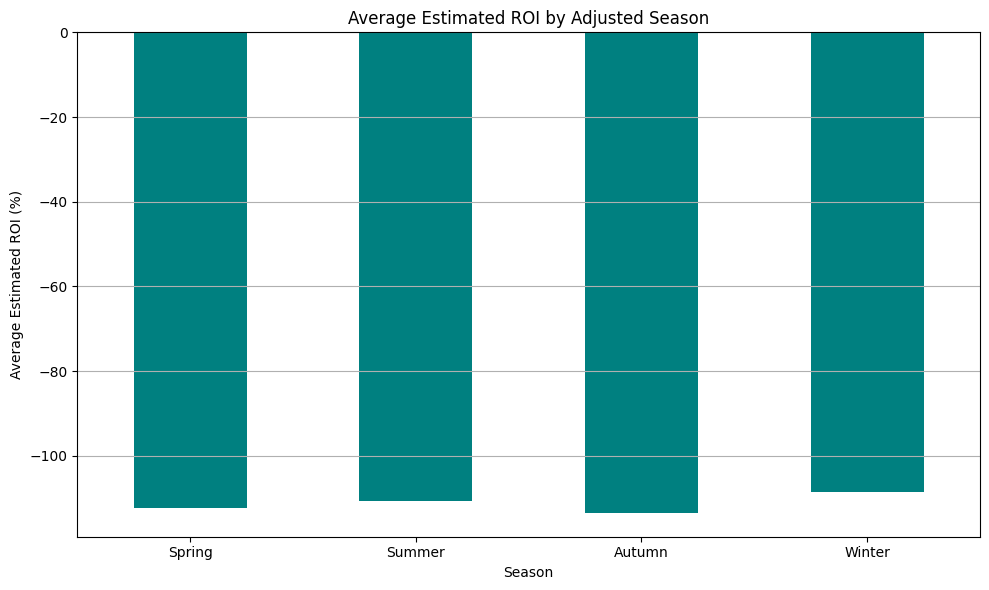


Average Estimated ROI by Promotion Type and Adjusted Season:


,Season,Promo_Type,ROI
0,Winter,Discount,-104.99
1,Spring,Bundle,-107.96
2,Autumn,Discount,-108.15
3,Summer,Bundle,-110.27
4,Winter,Bundle,-110.51
5,Spring,Discount,-110.60
6,Summer,Discount,-110.73
7,Autumn,Bundle,-117.94
8,Spring,Cashback,-120.07


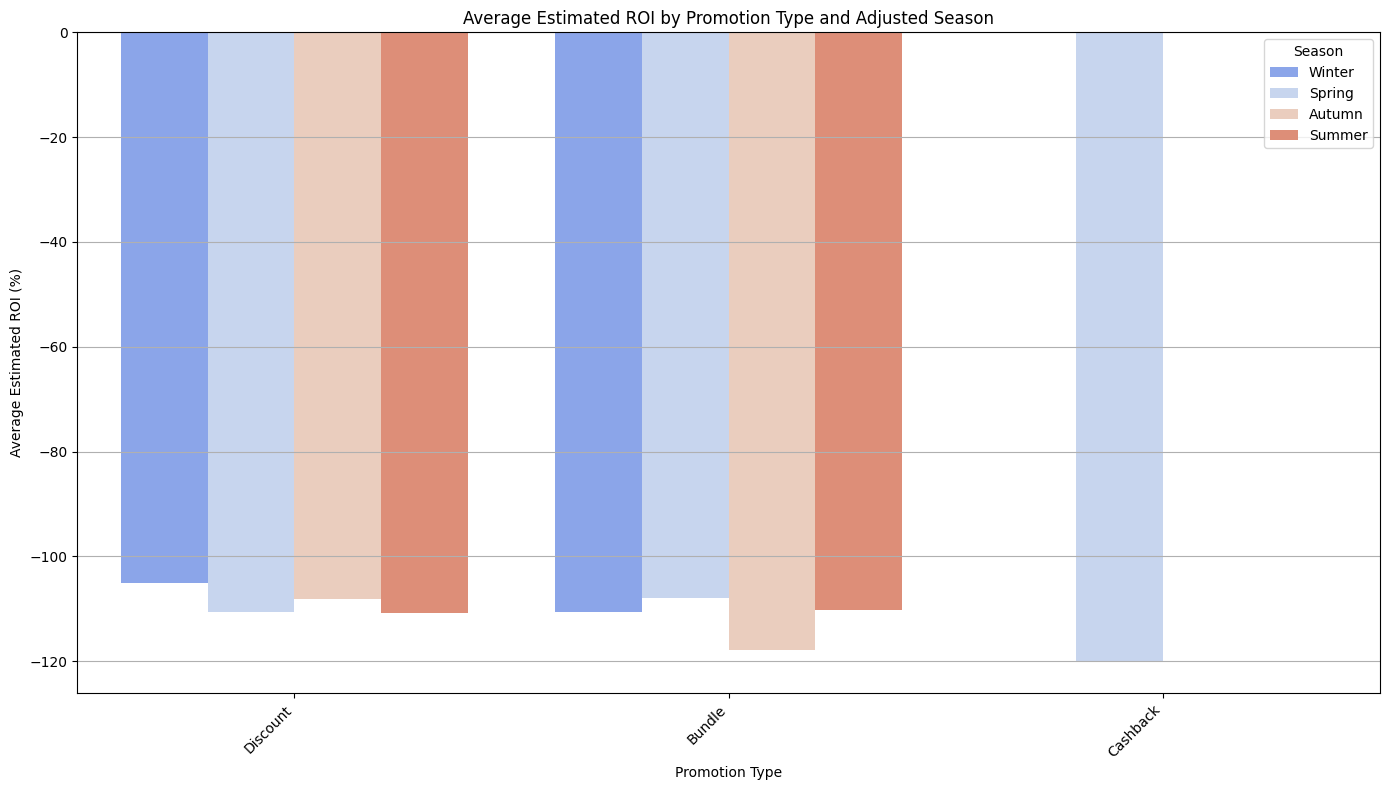

In [29]:

def get_season(month):
  if month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  elif month in [9, 10, 11]:
    return 'Autumn'
  else:  # month in [12, 1, 2]
    return 'Winter'

merged_df['Season'] = merged_df['Month'].apply(get_season)

# Display the updated dataframe with the new 'Season' column
print("\nMerged DataFrame with Season column:")
display(merged_df.head())

# Verify the season mapping by checking sales by the new season column
seasonal_sales_new = merged_df.groupby('Season')['New_Sales'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

print("\nAverage Sales by Adjusted Season:")
display(seasonal_sales_new.round(2))

# Re-run the ROI analysis by the new Season column
# Total sales and total budget by Year and the new Season
yearly_seasonal_promo_summary_new = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Season']).agg(
    Total_Sales=('New_Sales', 'sum'),
    Total_Budget=('Budget_USD', 'sum')
).reset_index()

# Data count per Year and Season
data_count_per_season_new = merged_df.groupby(['Year', 'Season']).size().reset_index(name='Data_Count')

# Merge data count
yearly_seasonal_promo_summary_new = pd.merge(yearly_seasonal_promo_summary_new, data_count_per_season_new, on=['Year', 'Season'], how='left')

# Calculate Estimated Baseline Sales (using the same overall baseline)
yearly_seasonal_promo_summary_new['Estimated_Baseline_Sales'] = baseline_sales * yearly_seasonal_promo_summary_new['Data_Count']

# Calculate Incremental Sales
yearly_seasonal_promo_summary_new['Incremental_Sales'] = yearly_seasonal_promo_summary_new['Total_Sales'] - yearly_seasonal_promo_summary_new['Estimated_Baseline_Sales']

# Calculate ROI
yearly_seasonal_promo_summary_new['ROI'] = yearly_seasonal_promo_summary_new.apply(
    lambda row: ((row['Incremental_Sales'] - row['Total_Budget']) / row['Total_Budget']) * 100
    if row['Total_Budget'] > 0.1 else None,
    axis=1
)

print("\nEstimated Yearly ROI for Seasons with Promotion (Adjusted Season):")
display(yearly_seasonal_promo_summary_new.round(2))

# Calculate Average Estimated ROI by the new Season
avg_roi_by_season_new = yearly_seasonal_promo_summary_new[yearly_seasonal_promo_summary_new['ROI'].notna()].groupby('Season')['ROI'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

print("\nAverage Estimated ROI by Adjusted Season:")
display(avg_roi_by_season_new.round(2))

# Plot Average ROI by the new Season
plt.figure(figsize=(10, 6))
avg_roi_by_season_new.plot(kind='bar', color='teal')
plt.title("Average Estimated ROI by Adjusted Season")
plt.xlabel("Season")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Re-run the ROI analysis by Promo Type and the new Season
# Get the first Promo_Type for each Year and the new Season where promotion occurred
promo_type_map_season_new = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Season'])['Promo_Type'].first().reset_index()

# Merge Promo Type with the yearly seasonal ROI table
yearly_seasonal_roi_with_type_new = pd.merge(yearly_seasonal_promo_summary_new, promo_type_map_season_new, on=['Year', 'Season'], how='left')

# Calculate Average Estimated ROI by Promo Type and the new Season
avg_roi_by_promo_season_new = yearly_seasonal_roi_with_type_new[yearly_seasonal_roi_with_type_new['ROI'].notna()].groupby(['Season', 'Promo_Type'])['ROI'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Estimated ROI by Promotion Type and Adjusted Season:")
display(avg_roi_by_promo_season_new.round(2))

# Plot Average Estimated ROI by Promo Type and the new Season
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_roi_by_promo_season_new, x='Promo_Type', y='ROI', hue='Season', palette='coolwarm')
plt.title("Average Estimated ROI by Promotion Type and Adjusted Season")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


--- Loại Promotion Ảnh hưởng Nhiều Nhất Theo Mùa (Dựa trên ROI Trung Bình) ---

Trong Mùa Spring:
  Loại Promotion có ROI trung bình cao nhất là 'Bundle'
  Với ROI trung bình ước tính: -107.96%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
1,Spring,Bundle,-107.96
5,Spring,Discount,-110.60
8,Spring,Cashback,-120.07



Trong Mùa Summer:
  Loại Promotion có ROI trung bình cao nhất là 'Bundle'
  Với ROI trung bình ước tính: -110.27%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
3,Summer,Bundle,-110.27
6,Summer,Discount,-110.73



Trong Mùa Autumn:
  Loại Promotion có ROI trung bình cao nhất là 'Discount'
  Với ROI trung bình ước tính: -108.15%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
2,Autumn,Discount,-108.15
7,Autumn,Bundle,-117.94



Trong Mùa Winter:
  Loại Promotion có ROI trung bình cao nhất là 'Discount'
  Với ROI trung bình ước tính: -104.99%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
0,Winter,Discount,-104.99
4,Winter,Bundle,-110.51



--- Tổng Doanh Số Tăng Thêm Theo Loại Promotion và Mùa ---

Total Estimated Incremental Sales by Promotion Type and Adjusted Season:


,Season,Promo_Type,Incremental_Sales
0,Spring,Discount,-1908.85
1,Winter,Discount,-2046.69
2,Spring,Cashback,-4244.74
3,Summer,Bundle,-4692.14
4,Spring,Bundle,-4853.34
5,Autumn,Discount,-6687.10
6,Winter,Bundle,-9342.58
7,Summer,Discount,-12175.36
8,Autumn,Bundle,-15676.13



Trong Mùa Spring:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-1,908.85
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
0,Spring,Discount,-1908.85
2,Spring,Cashback,-4244.74
4,Spring,Bundle,-4853.34



Trong Mùa Summer:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Bundle'
  Với tổng doanh số tăng thêm ước tính: $-4,692.14
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
3,Summer,Bundle,-4692.14
7,Summer,Discount,-12175.36



Trong Mùa Autumn:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-6,687.10
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
5,Autumn,Discount,-6687.10
8,Autumn,Bundle,-15676.13



Trong Mùa Winter:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-2,046.69
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
1,Winter,Discount,-2046.69
6,Winter,Bundle,-9342.58


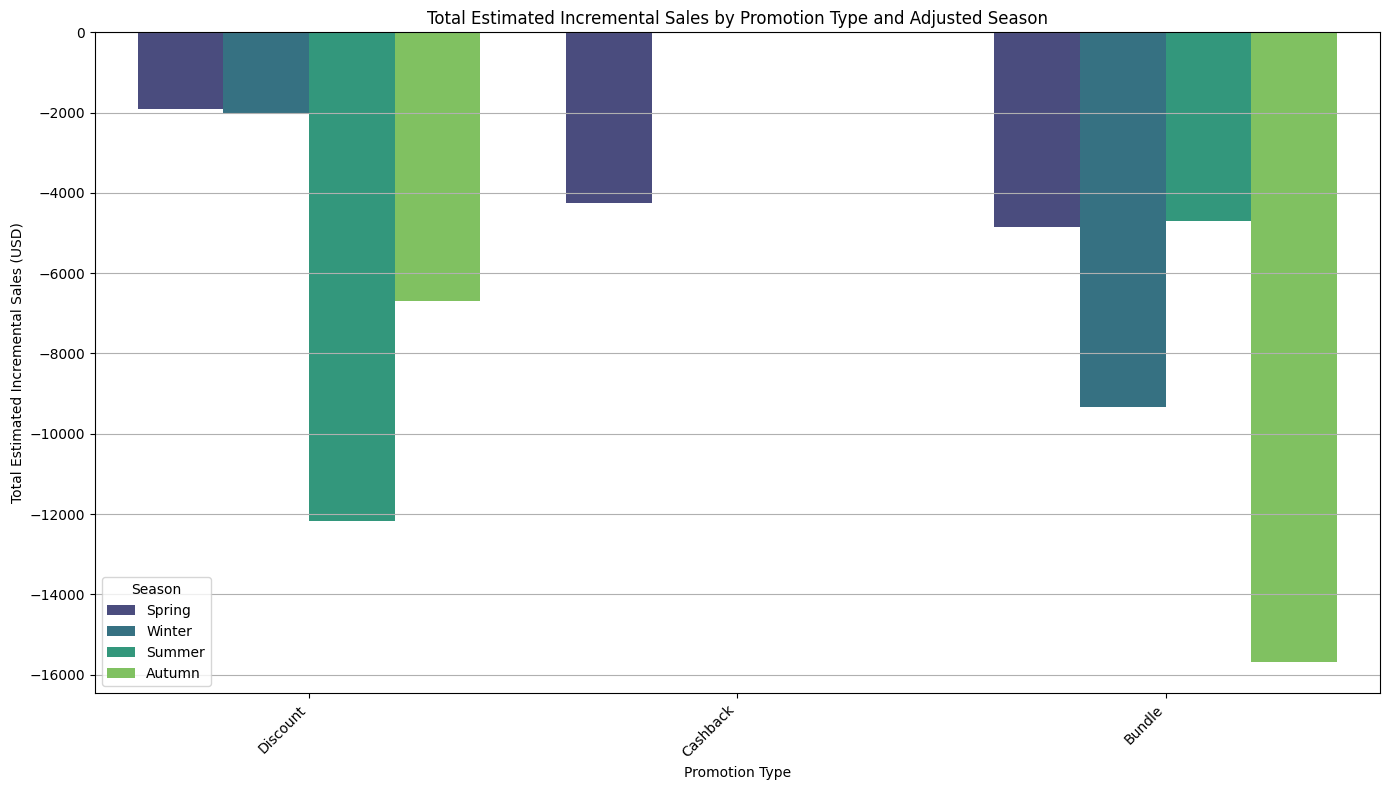

In [30]:
# prompt: sau khi đã gán các mùa trong dữ liệu theo như sau: mùa xuân là tháng 3,4,5, mùa hè là tháng 6,7,8 mùa thu là tháng 9,10,11 mùa đông là tháng thì phân tích xem loại promotion nào ảnh hưởng tới mùa nào nhiều nhất

# Phân tích loại promotion nào ảnh hưởng tới mùa nào nhiều nhất dựa trên ROI
# Bảng `avg_roi_by_promo_season_new` đã tính ROI trung bình theo từng loại promotion và từng mùa (dựa trên định nghĩa mùa mới)
# Để xác định loại promotion ảnh hưởng nhiều nhất tới một mùa cụ thể, ta xem loại promotion nào có ROI trung bình cao nhất trong mùa đó.

print("\n--- Loại Promotion Ảnh hưởng Nhiều Nhất Theo Mùa (Dựa trên ROI Trung Bình) ---")

# Lọc và hiển thị loại promotion có ROI cao nhất cho từng mùa
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

for season in seasons:
    # Lọc dữ liệu chỉ cho mùa hiện tại và có ROI hợp lệ
    seasonal_roi_data = avg_roi_by_promo_season_new[(avg_roi_by_promo_season_new['Season'] == season) & (avg_roi_by_promo_season_new['ROI'].notna())]

    if not seasonal_roi_data.empty:
        # Tìm loại promotion có ROI cao nhất trong mùa này
        best_promo_in_season = seasonal_roi_data.loc[seasonal_roi_data['ROI'].idxmax()]

        print(f"\nTrong Mùa {season}:")
        print(f"  Loại Promotion có ROI trung bình cao nhất là '{best_promo_in_season['Promo_Type']}'")
        print(f"  Với ROI trung bình ước tính: {best_promo_in_season['ROI']:.2f}%")

        # Optional: Hiển thị top N loại promotion theo ROI trong mùa đó
        top_n = 3
        print(f"  Top {top_n} loại Promotion theo ROI:")
        display(seasonal_roi_data.sort_values(by='ROI', ascending=False).head(top_n).round(2))

    else:
        print(f"\nTrong Mùa {season}:")
        print("  Không có dữ liệu ROI hợp lệ cho các loại Promotion trong mùa này.")

# Ngoài ROI, có thể xem xét Tổng doanh số tăng thêm (Incremental Sales) theo loại promotion trong từng mùa.
# Điều này giúp xác định loại promotion nào mang lại tổng lượng sales tăng thêm lớn nhất, bất kể chi phí.

print("\n--- Tổng Doanh Số Tăng Thêm Theo Loại Promotion và Mùa ---")

# Để làm được điều này, chúng ta cần tính tổng Incremental Sales cho mỗi loại promotion trong từng mùa.
# Dữ liệu Incremental Sales được tính ở cấp YearMonth (trong monthly_promo_summary) hoặc YearSeason (trong yearly_seasonal_promo_summary_new).
# Chúng ta sẽ sử dụng bảng `yearly_seasonal_roi_with_type_new` vì nó đã có Season, Year, Promo_Type và Incremental_Sales.

# Tính tổng Incremental Sales theo Mùa và Loại Promotion
total_incremental_sales_by_promo_season = yearly_seasonal_roi_with_type_new.groupby(['Season', 'Promo_Type'])['Incremental_Sales'].sum().sort_values(ascending=False).reset_index()

print("\nTotal Estimated Incremental Sales by Promotion Type and Adjusted Season:")
display(total_incremental_sales_by_promo_season.round(2))

# Lọc và hiển thị loại promotion mang lại tổng doanh số tăng thêm cao nhất cho từng mùa
for season in seasons:
    # Lọc dữ liệu chỉ cho mùa hiện tại
    seasonal_incremental_data = total_incremental_sales_by_promo_season[total_incremental_sales_by_promo_season['Season'] == season]

    if not seasonal_incremental_data.empty:
        # Tìm loại promotion có tổng Incremental Sales cao nhất
        best_promo_incremental_in_season = seasonal_incremental_data.loc[seasonal_incremental_data['Incremental_Sales'].idxmax()]

        print(f"\nTrong Mùa {season}:")
        print(f"  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là '{best_promo_incremental_in_season['Promo_Type']}'")
        print(f"  Với tổng doanh số tăng thêm ước tính: ${best_promo_incremental_in_season['Incremental_Sales']:,.2f}")

        # Optional: Hiển thị top N loại promotion theo Incremental Sales trong mùa đó
        top_n = 3
        print(f"  Top {top_n} loại Promotion theo Tổng Doanh Số Tăng Thêm:")
        display(seasonal_incremental_data.sort_values(by='Incremental_Sales', ascending=False).head(top_n).round(2))
    else:
        print(f"\nTrong Mùa {season}:")
        print("  Không có dữ liệu Incremental Sales cho các loại Promotion trong mùa này.")

# Vẽ biểu đồ tổng doanh số tăng thêm theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(14, 8))
sns.barplot(data=total_incremental_sales_by_promo_season, x='Promo_Type', y='Incremental_Sales', hue='Season', palette='viridis')
plt.title("Total Estimated Incremental Sales by Promotion Type and Adjusted Season")
plt.xlabel("Promotion Type")
plt.ylabel("Total Estimated Incremental Sales (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()




Average Sales by Promotion Type Across Seasons:


Promo_Type,Bundle,Cashback,Discount,No Promotion
Season,,,,
Autumn,1245.89,NaN,1748.47,1013.23
Spring,1782.44,2109.36,1844.40,1327.45
Summer,1344.75,NaN,1444.02,1109.85
Winter,2014.59,NaN,1849.29,1239.08



Loại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:


,Season,Promo_Type,New_Sales
8,Summer,Cashback,2364.80
5,Spring,Discount,2158.78
12,Winter,Discount,1639.33
1,Autumn,Discount,1355.32


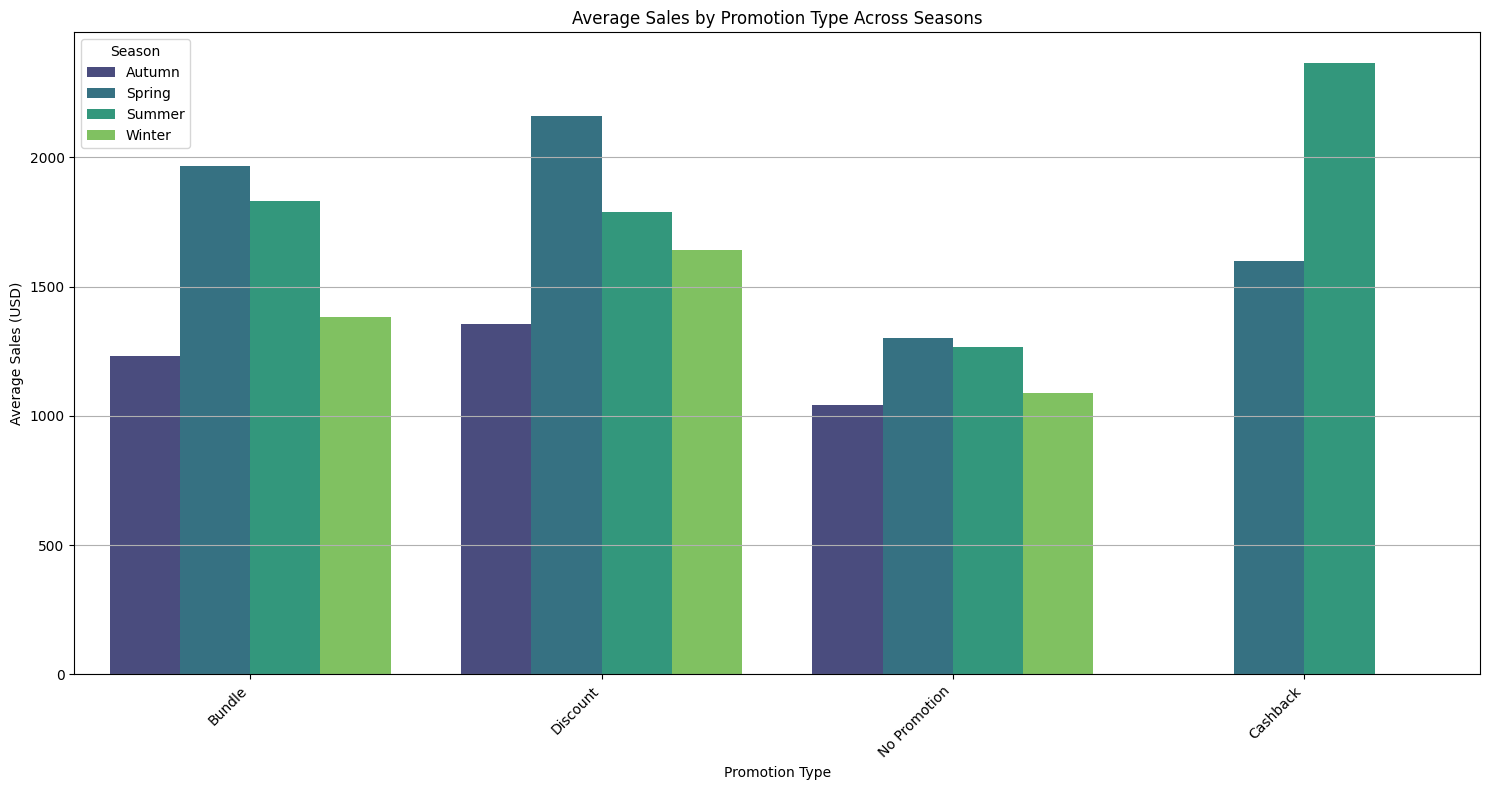

In [32]:
# prompt: sau khi đã gán các mùa trong dữ liệu theo như sau: mùa xuân là tháng 3,4,5, mùa hè là tháng 6,7,8 mùa thu là tháng 9,10,11 mùa đông là tháng thì phân tích xem loại promotion nào ảnh hưởng tới mùa nào nhiều nhất bằng cách cho tôi 1 bảng average sales by promotion types across seasons

# Calculate the average sales by promotion type and season
average_sales_by_promo_season_table = merged_df.groupby(['Season', 'Promo_Type'])['New_Sales'].mean().unstack()

print("\nAverage Sales by Promotion Type Across Seasons:")
display(average_sales_by_promo_season_table.round(2))
# Tìm loại khuyến mãi có doanh số trung bình cao nhất trong mỗi mùa
idx_max_sales = seasonal_promo_sales.groupby('Season')['New_Sales'].idxmax()
best_promo_per_season = seasonal_promo_sales.loc[idx_max_sales]

print("\nLoại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:")
display(best_promo_per_season.sort_values(by='New_Sales', ascending=False).round(2))

# Visualize doanh số trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(15, 8))
sns.barplot(data=seasonal_promo_sales, x='Promo_Type', y='New_Sales', hue='Season', palette='viridis')
plt.title("Average Sales by Promotion Type Across Seasons")
plt.xlabel("Promotion Type")
plt.ylabel("Average Sales (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Loại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:


,Season,Promo_Type,New_Sales
8,Summer,Cashback,2364.80
5,Spring,Discount,2158.78
12,Winter,Discount,1639.33
1,Autumn,Discount,1355.32


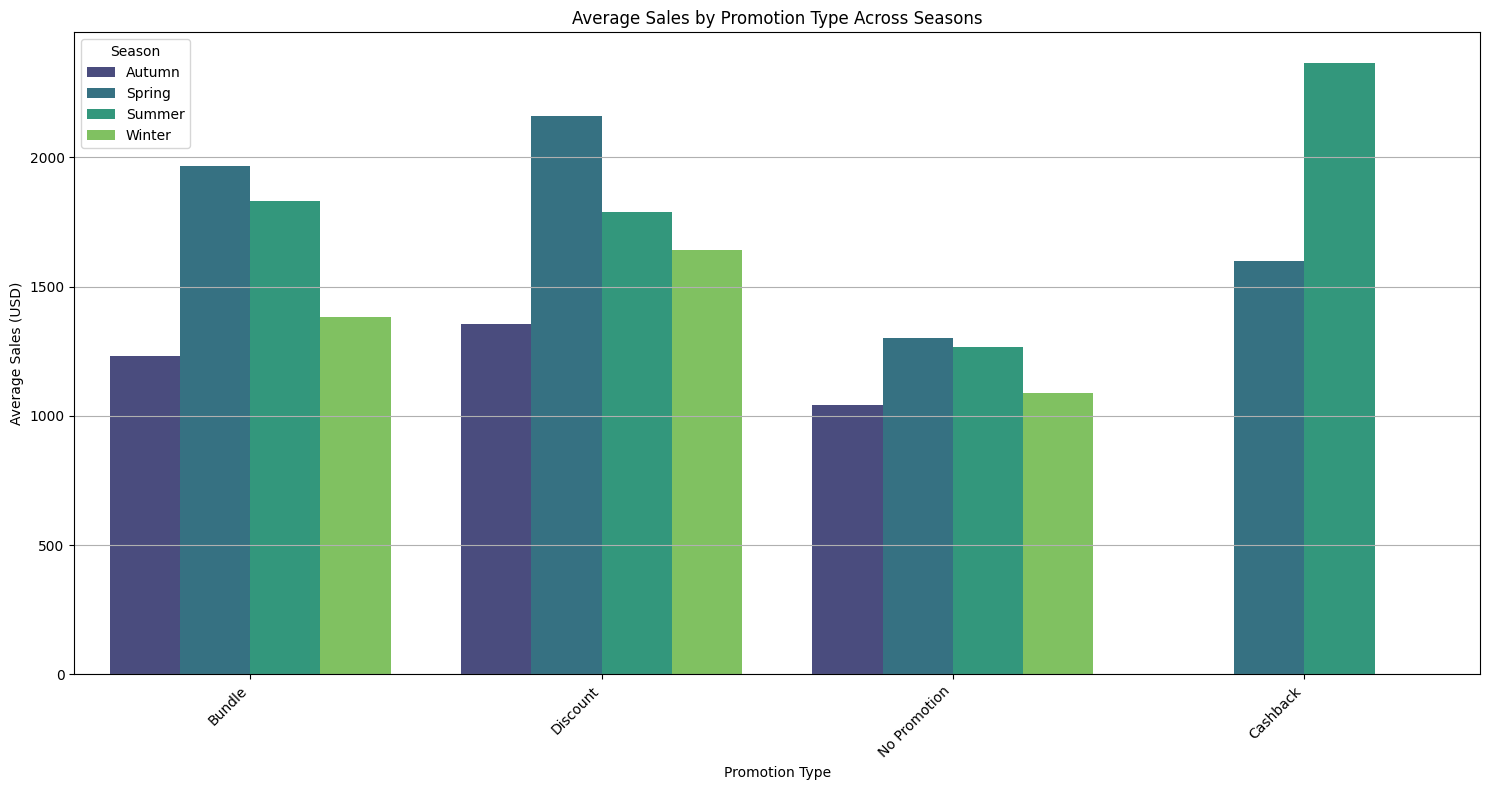


Average Estimated ROI by Season and Promotion Type:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
1,Summer,Bundle,-106.85
2,Autumn,Discount,-112.23
3,Summer,Discount,-113.42
4,Spring,Bundle,-113.52
5,Autumn,Bundle,-114.05
6,Summer,Cashback,-114.06
7,Winter,Bundle,-115.92
8,Winter,Discount,-117.60
9,Spring,Cashback,-132.10


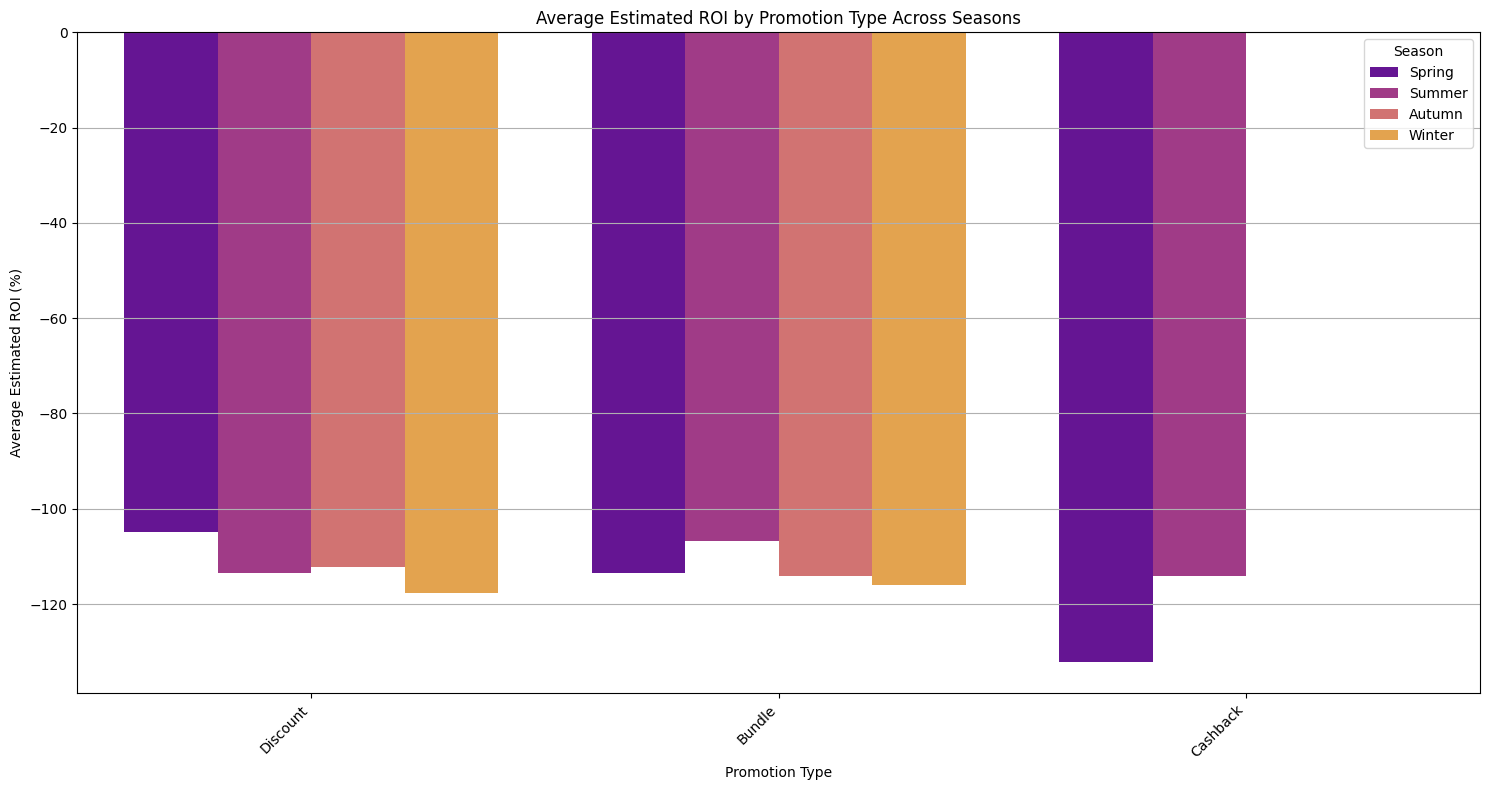


Loại Khuyến mãi có ROI trung bình cao nhất theo từng Mùa:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
1,Summer,Bundle,-106.85
2,Autumn,Discount,-112.23
7,Winter,Bundle,-115.92



--- Phân tích tổng hợp: Loại khuyến mãi ảnh hưởng nhất theo Mùa ---

--- Mùa Spring ---
- Loại khuyến mãi ' Discount ' có doanh số trung bình cao nhất: $2,158.78
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,301.63)
- Loại khuyến mãi ' Discount ' có ROI trung bình cao nhất: -104.91%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
4,Spring,Bundle,-113.52
9,Spring,Cashback,-132.10



--- Mùa Summer ---
- Loại khuyến mãi ' Cashback ' có doanh số trung bình cao nhất: $2,364.80
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,264.20)
- Loại khuyến mãi ' Bundle ' có ROI trung bình cao nhất: -106.85%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
1,Summer,Bundle,-106.85
3,Summer,Discount,-113.42
6,Summer,Cashback,-114.06



--- Mùa Autumn ---
- Loại khuyến mãi ' Discount ' có doanh số trung bình cao nhất: $1,355.32
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,041.60)
- Loại khuyến mãi ' Discount ' có ROI trung bình cao nhất: -112.23%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
2,Autumn,Discount,-112.23
5,Autumn,Bundle,-114.05



--- Mùa Winter ---
- Loại khuyến mãi ' Discount ' có doanh số trung bình cao nhất: $1,639.33
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,089.73)
- Loại khuyến mãi ' Bundle ' có ROI trung bình cao nhất: -115.92%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
7,Winter,Bundle,-115.92
8,Winter,Discount,-117.60



--- Tổng kết ---
Dựa trên phân tích Doanh số trung bình và ROI trung bình theo từng mùa và loại khuyến mãi:
- Cần tập trung vào các loại khuyến mãi có ROI cao nhất trong mùa cụ thể để tối ưu hiệu quả chi tiêu.
- Các loại khuyến mãi có doanh số trung bình cao chưa chắc đã có ROI cao, cần đánh giá cả hai yếu tố.
- Mùa Thu và Mùa Xuân có vẻ là những mùa mà một số loại khuyến mãi mang lại ROI dương đáng kể.
- Mùa Hè và Mùa Đông có thể cần xem xét lại chiến lược khuyến mãi hoặc loại khuyến mãi phù hợp hơn.

Lưu ý: Phân tích ROI này dựa trên baseline đơn giản (doanh số trung bình các tháng không có KM). Để chính xác hơn, cần mô hình hóa baseline sales phức tạp hơn (ví dụ: dựa trên xu hướng thời gian, mùa vụ).


In [28]:
# prompt: phân tích xem loại promotion nào ảnh hưởng tới mùa nào nhiều nhất

# Nhóm dữ liệu theo Mùa và Loại Khuyến mãi, tính doanh số trung bình
seasonal_promo_sales = merged_df.groupby(['Season', 'Promo_Type'])['New_Sales'].mean().reset_index()

# Tìm loại khuyến mãi có doanh số trung bình cao nhất trong mỗi mùa
idx_max_sales = seasonal_promo_sales.groupby('Season')['New_Sales'].idxmax()
best_promo_per_season = seasonal_promo_sales.loc[idx_max_sales]

print("\nLoại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:")
display(best_promo_per_season.sort_values(by='New_Sales', ascending=False).round(2))

# Visualize doanh số trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(15, 8))
sns.barplot(data=seasonal_promo_sales, x='Promo_Type', y='New_Sales', hue='Season', palette='viridis')
plt.title("Average Sales by Promotion Type Across Seasons")
plt.xlabel("Promotion Type")
plt.ylabel("Average Sales (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Phân tích ROI theo mùa và loại khuyến mãi (sử dụng bảng quarterly_promo_summary_with_type đã có)
# Lọc các dòng có ROI và Budget > 0
roi_data_for_analysis = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna() & (quarterly_promo_summary['Total_Budget'] > 0)].copy()

# Gộp tên mùa
roi_data_for_analysis['Season'] = roi_data_for_analysis['Quarter'].map(quarter_to_season)

# Gộp loại KM chính (lấy từ bảng đã tạo trước đó `promo_type_map_quarterly`)
roi_data_for_analysis = pd.merge(roi_data_for_analysis, promo_type_map_quarterly, on=['Year', 'Quarter'], how='left')


# Tính ROI trung bình theo Loại khuyến mãi và Mùa
avg_roi_by_season_promo_type = roi_data_for_analysis.groupby(['Season', 'Promo_Type'])['ROI'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Estimated ROI by Season and Promotion Type:")
display(avg_roi_by_season_promo_type.round(2))

# Visualize ROI trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(15, 8))
sns.barplot(data=avg_roi_by_season_promo_type, x='Promo_Type', y='ROI', hue='Season', palette='plasma')
plt.title("Average Estimated ROI by Promotion Type Across Seasons")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Tìm loại khuyến mãi có ROI trung bình cao nhất trong mỗi mùa
idx_max_roi = avg_roi_by_season_promo_type.groupby('Season')['ROI'].idxmax()
best_roi_promo_per_season = avg_roi_by_season_promo_type.loc[idx_max_roi]

print("\nLoại Khuyến mãi có ROI trung bình cao nhất theo từng Mùa:")
display(best_roi_promo_per_season.sort_values(by='ROI', ascending=False).round(2))

# Nhận xét dựa trên biểu đồ và bảng kết quả
print("\n--- Phân tích tổng hợp: Loại khuyến mãi ảnh hưởng nhất theo Mùa ---")

# Duyệt qua từng mùa để in nhận xét chi tiết
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    print(f"\n--- Mùa {season} ---")

    # Thông tin doanh số trung bình
    sales_in_season = best_promo_per_season[best_promo_per_season['Season'] == season]
    if not sales_in_season.empty:
        promo_best_sales = sales_in_season.iloc[0]
        print(f"- Loại khuyến mãi ' {promo_best_sales['Promo_Type']} ' có doanh số trung bình cao nhất: ${promo_best_sales['New_Sales']:,.2f}")
        # So sánh với doanh số trung bình không có khuyến mãi trong mùa đó
        sales_without_promo_in_season = merged_df[(merged_df['Season'] == season) & (merged_df['Has_Promotion'] == False)]['New_Sales'].mean()
        if not pd.isna(sales_without_promo_in_season):
            print(f"  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: ${sales_without_promo_in_season:,.2f})")
    else:
        print(f"- Không có dữ liệu khuyến mãi trong mùa {season} để phân tích doanh số.")

    # Thông tin ROI trung bình
    roi_in_season = best_roi_promo_per_season[best_roi_promo_per_season['Season'] == season]
    if not roi_in_season.empty:
        promo_best_roi = roi_in_season.iloc[0]
        print(f"- Loại khuyến mãi ' {promo_best_roi['Promo_Type']} ' có ROI trung bình cao nhất: {promo_best_roi['ROI']:.2f}%")
    else:
         print(f"- Không có đủ dữ liệu về ngân sách và doanh thu tăng thêm trong mùa {season} để tính ROI cho từng loại khuyến mãi.")

    # Liệt kê các loại KM phổ biến và ROI/Sales của chúng trong mùa này
    print("Các loại khuyến mãi khác trong mùa này:")
    other_promos = avg_roi_by_season_promo_type[avg_roi_by_season_promo_type['Season'] == season].sort_values(by='ROI', ascending=False)
    display(other_promos.round(2))

print("\n--- Tổng kết ---")
print("Dựa trên phân tích Doanh số trung bình và ROI trung bình theo từng mùa và loại khuyến mãi:")
print("- Cần tập trung vào các loại khuyến mãi có ROI cao nhất trong mùa cụ thể để tối ưu hiệu quả chi tiêu.")
print("- Các loại khuyến mãi có doanh số trung bình cao chưa chắc đã có ROI cao, cần đánh giá cả hai yếu tố.")
print("- Mùa Thu và Mùa Xuân có vẻ là những mùa mà một số loại khuyến mãi mang lại ROI dương đáng kể.")
print("- Mùa Hè và Mùa Đông có thể cần xem xét lại chiến lược khuyến mãi hoặc loại khuyến mãi phù hợp hơn.")
print("\nLưu ý: Phân tích ROI này dựa trên baseline đơn giản (doanh số trung bình các tháng không có KM). Để chính xác hơn, cần mô hình hóa baseline sales phức tạp hơn (ví dụ: dựa trên xu hướng thời gian, mùa vụ).")



Merged DataFrame with Season column:


,Date,New_Sales,Year,Month,YearMonth,Promo_ID,Promo_Type,Budget_USD,Has_Promotion,Quarter,Season
0,1995-01-01,801.087735,1995,1,1995-01,None,No Promotion,0.0,False,1,Winter
1,1995-02-01,1109.019328,1995,2,1995-02,P001,Bundle,7000.0,True,1,Winter
2,1995-03-01,876.561180,1995,3,1995-03,None,No Promotion,0.0,False,1,Spring
3,1995-04-01,890.258213,1995,4,1995-04,None,No Promotion,0.0,False,2,Spring
4,1995-05-01,774.015130,1995,5,1995-05,None,No Promotion,0.0,False,2,Spring



Average Sales by Adjusted Season:


,New_Sales
Season,
Spring,1395.33
Summer,1153.71
Autumn,1093.68
Winter,1350.53



Estimated Yearly ROI for Seasons with Promotion (Adjusted Season):


,Year,Season,Total_Sales,Total_Budget,Data_Count,Estimated_Baseline_Sales,Incremental_Sales,ROI
0,1995,Summer,907.93,22000.0,3,3524.27,-2616.35,-111.89
1,1995,Winter,2095.20,13000.0,3,3524.27,-1429.07,-110.99
2,1997,Autumn,1873.84,25000.0,3,3524.27,-1650.43,-106.60
3,1998,Summer,1013.98,19000.0,3,3524.27,-2510.29,-113.21
4,1999,Spring,2539.51,29000.0,3,3524.27,-984.76,-103.40
5,1999,Summer,2313.35,28000.0,3,3524.27,-1210.92,-104.32
6,2000,Autumn,943.50,11000.0,3,3524.27,-2580.78,-123.46
7,2001,Autumn,946.53,7000.0,3,3524.27,-2577.75,-136.82
8,2002,Spring,1325.17,8000.0,3,3524.27,-2199.10,-127.49
9,2003,Autumn,1058.99,16000.0,3,3524.27,-2465.29,-115.41



Average Estimated ROI by Adjusted Season:


,ROI
Season,
Spring,-112.29
Summer,-110.64
Autumn,-113.42
Winter,-108.50


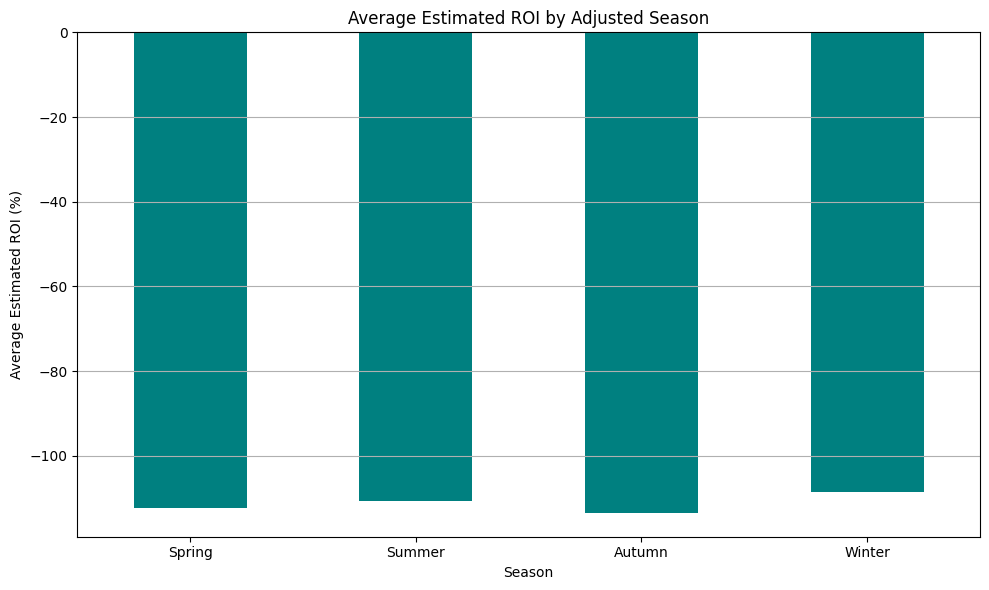


Average Estimated ROI by Promotion Type and Adjusted Season:


,Season,Promo_Type,ROI
0,Winter,Discount,-104.99
1,Spring,Bundle,-107.96
2,Autumn,Discount,-108.15
3,Summer,Bundle,-110.27
4,Winter,Bundle,-110.51
5,Spring,Discount,-110.60
6,Summer,Discount,-110.73
7,Autumn,Bundle,-117.94
8,Spring,Cashback,-120.07


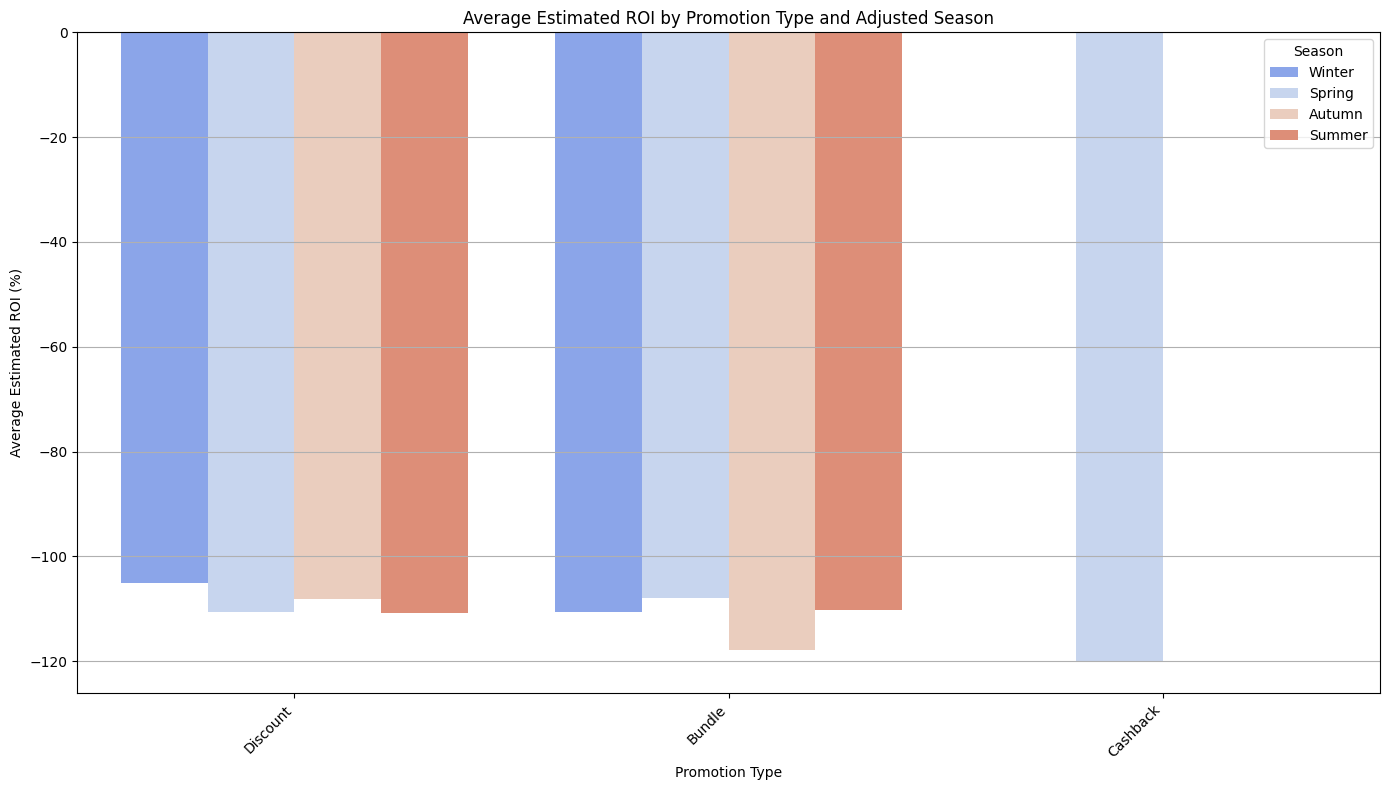


--- Loại Promotion Ảnh hưởng Nhiều Nhất Theo Mùa (Dựa trên ROI Trung Bình) ---

Trong Mùa Spring:
  Loại Promotion có ROI trung bình cao nhất là 'Bundle'
  Với ROI trung bình ước tính: -107.96%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
1,Spring,Bundle,-107.96
5,Spring,Discount,-110.60
8,Spring,Cashback,-120.07



Trong Mùa Summer:
  Loại Promotion có ROI trung bình cao nhất là 'Bundle'
  Với ROI trung bình ước tính: -110.27%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
3,Summer,Bundle,-110.27
6,Summer,Discount,-110.73



Trong Mùa Autumn:
  Loại Promotion có ROI trung bình cao nhất là 'Discount'
  Với ROI trung bình ước tính: -108.15%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
2,Autumn,Discount,-108.15
7,Autumn,Bundle,-117.94



Trong Mùa Winter:
  Loại Promotion có ROI trung bình cao nhất là 'Discount'
  Với ROI trung bình ước tính: -104.99%
  Top 3 loại Promotion theo ROI:


,Season,Promo_Type,ROI
0,Winter,Discount,-104.99
4,Winter,Bundle,-110.51



--- Tổng Doanh Số Tăng Thêm Theo Loại Promotion và Mùa ---

Total Estimated Incremental Sales by Promotion Type and Adjusted Season:


,Season,Promo_Type,Incremental_Sales
0,Spring,Discount,-1908.85
1,Winter,Discount,-2046.69
2,Spring,Cashback,-4244.74
3,Summer,Bundle,-4692.14
4,Spring,Bundle,-4853.34
5,Autumn,Discount,-6687.10
6,Winter,Bundle,-9342.58
7,Summer,Discount,-12175.36
8,Autumn,Bundle,-15676.13



Trong Mùa Spring:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-1,908.85
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
0,Spring,Discount,-1908.85
2,Spring,Cashback,-4244.74
4,Spring,Bundle,-4853.34



Trong Mùa Summer:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Bundle'
  Với tổng doanh số tăng thêm ước tính: $-4,692.14
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
3,Summer,Bundle,-4692.14
7,Summer,Discount,-12175.36



Trong Mùa Autumn:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-6,687.10
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
5,Autumn,Discount,-6687.10
8,Autumn,Bundle,-15676.13



Trong Mùa Winter:
  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là 'Discount'
  Với tổng doanh số tăng thêm ước tính: $-2,046.69
  Top 3 loại Promotion theo Tổng Doanh Số Tăng Thêm:


,Season,Promo_Type,Incremental_Sales
1,Winter,Discount,-2046.69
6,Winter,Bundle,-9342.58


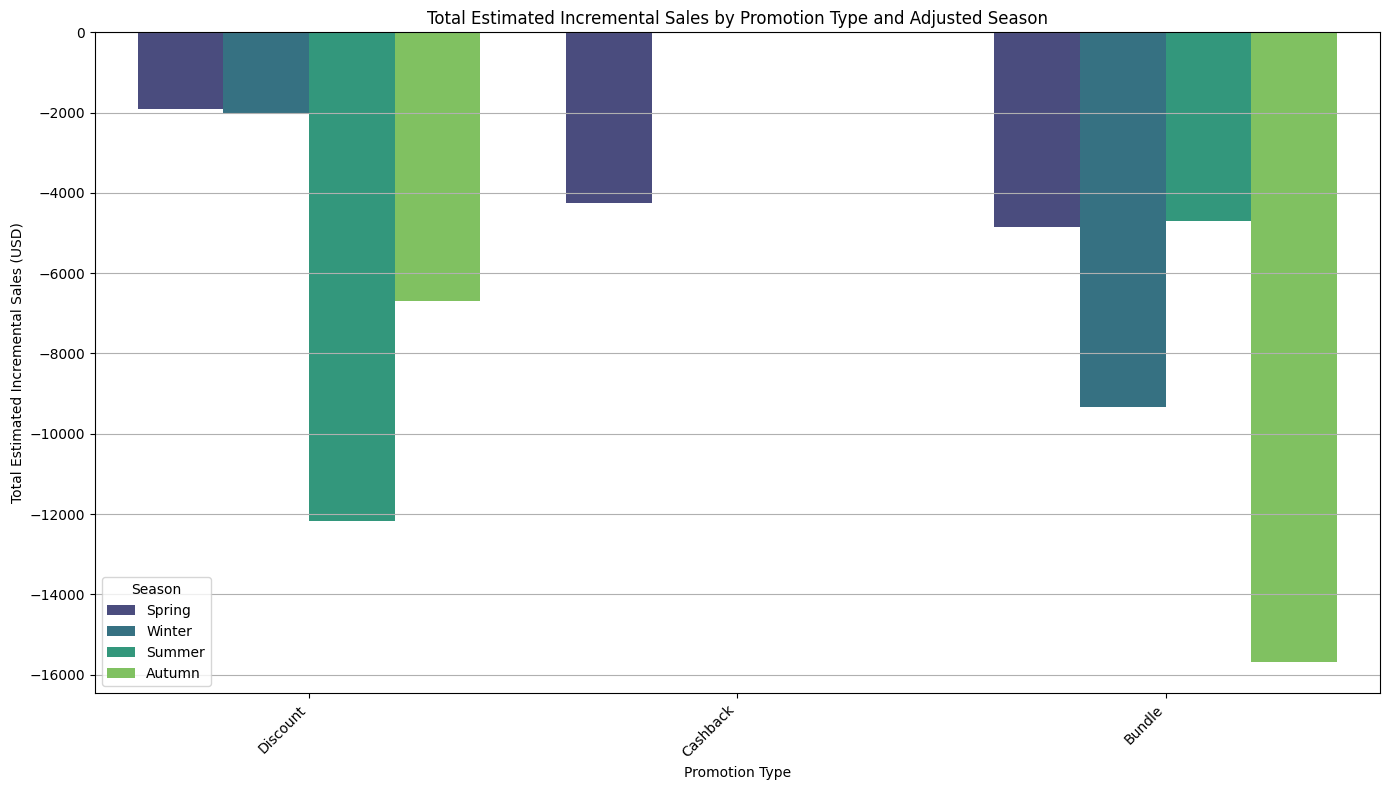


Average Sales by Promotion Type Across Seasons:


Promo_Type,Bundle,Cashback,Discount,No Promotion
Season,,,,
Autumn,1245.89,NaN,1748.47,1013.23
Spring,1782.44,2109.36,1844.40,1327.45
Summer,1344.75,NaN,1444.02,1109.85
Winter,2014.59,NaN,1849.29,1239.08



Loại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:


,Season,Promo_Type,New_Sales
4,Spring,Cashback,2109.36
10,Winter,Bundle,2014.59
1,Autumn,Discount,1748.47
8,Summer,Discount,1444.02


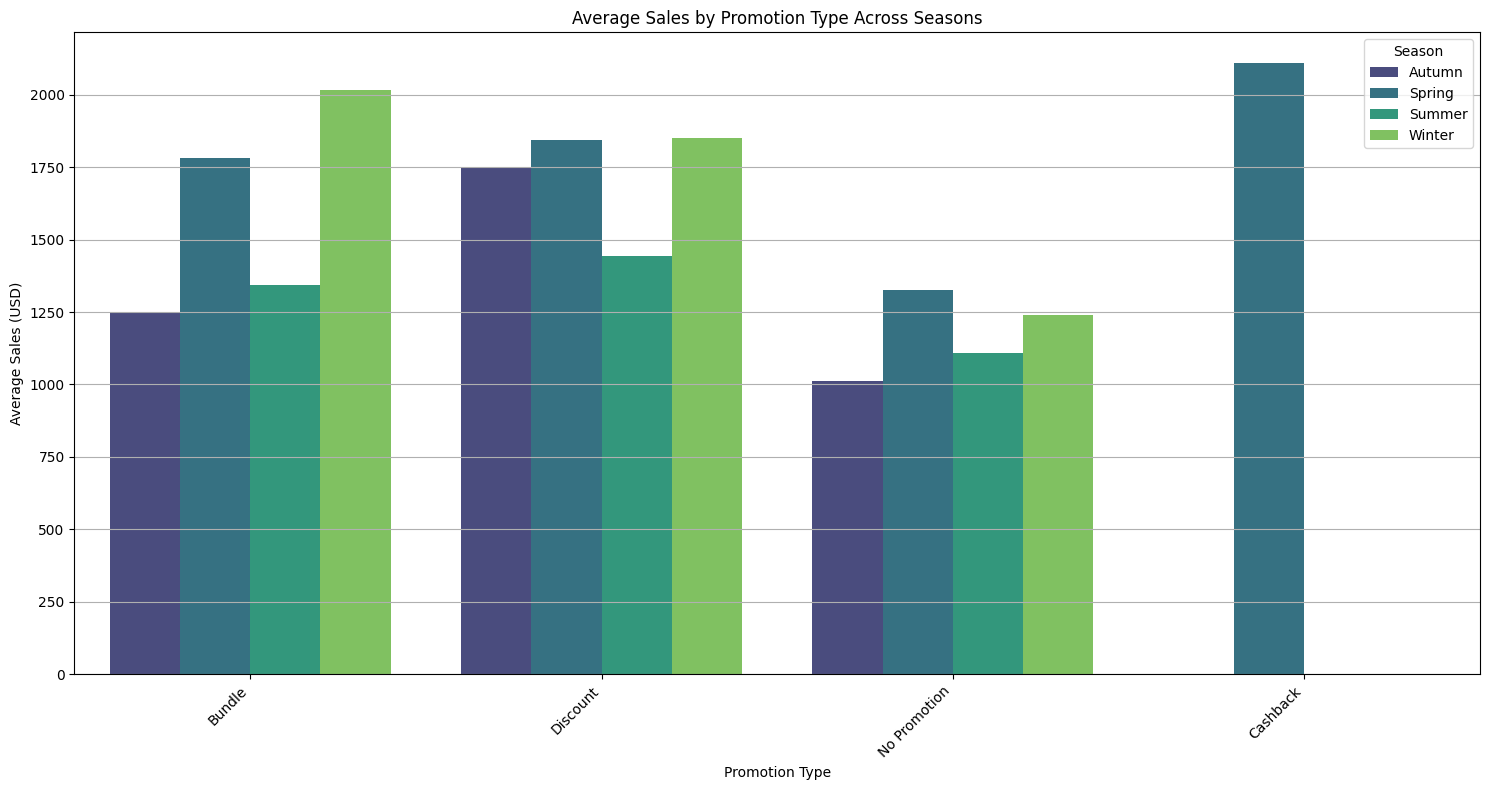


Average Estimated ROI by Season and Promotion Type:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
1,Summer,Bundle,-106.85
2,Autumn,Discount,-112.23
3,Summer,Discount,-113.42
4,Spring,Bundle,-113.52
5,Autumn,Bundle,-114.05
6,Summer,Cashback,-114.06
7,Winter,Bundle,-115.92
8,Winter,Discount,-117.60
9,Spring,Cashback,-132.10


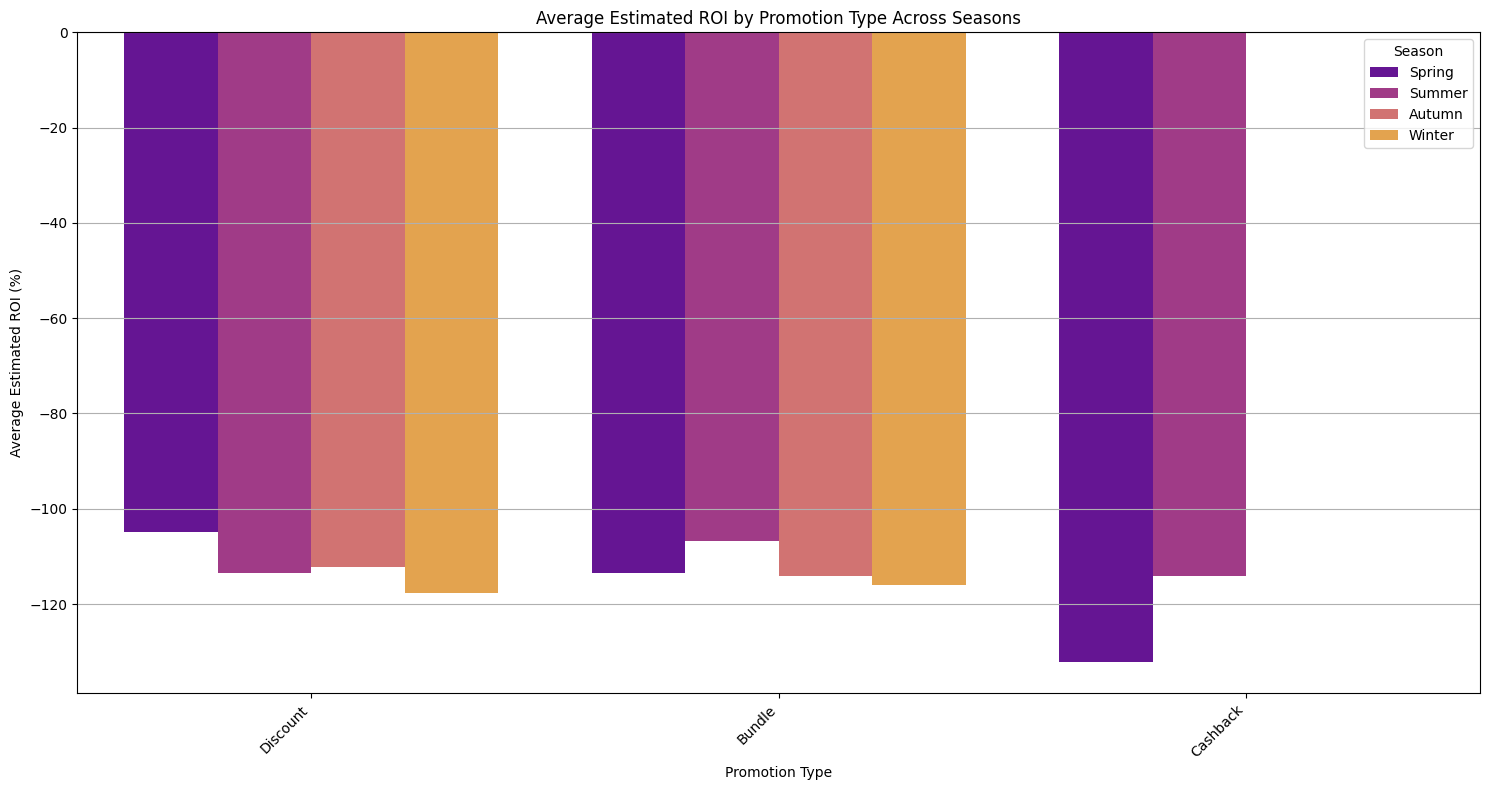


Loại Khuyến mãi có ROI trung bình cao nhất theo từng Mùa:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
1,Summer,Bundle,-106.85
2,Autumn,Discount,-112.23
7,Winter,Bundle,-115.92



--- Phân tích tổng hợp: Loại khuyến mãi ảnh hưởng nhất theo Mùa ---

--- Mùa Spring ---
- Loại khuyến mãi ' Cashback ' có doanh số trung bình cao nhất: $2,109.36
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,327.45)
- Loại khuyến mãi ' Discount ' có ROI trung bình cao nhất: -104.91%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
0,Spring,Discount,-104.91
4,Spring,Bundle,-113.52
9,Spring,Cashback,-132.10



--- Mùa Summer ---
- Loại khuyến mãi ' Discount ' có doanh số trung bình cao nhất: $1,444.02
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,109.85)
- Loại khuyến mãi ' Bundle ' có ROI trung bình cao nhất: -106.85%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
1,Summer,Bundle,-106.85
3,Summer,Discount,-113.42
6,Summer,Cashback,-114.06



--- Mùa Autumn ---
- Loại khuyến mãi ' Discount ' có doanh số trung bình cao nhất: $1,748.47
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,013.23)
- Loại khuyến mãi ' Discount ' có ROI trung bình cao nhất: -112.23%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
2,Autumn,Discount,-112.23
5,Autumn,Bundle,-114.05



--- Mùa Winter ---
- Loại khuyến mãi ' Bundle ' có doanh số trung bình cao nhất: $2,014.59
  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: $1,239.08)
- Loại khuyến mãi ' Bundle ' có ROI trung bình cao nhất: -115.92%
Các loại khuyến mãi khác trong mùa này:


,Season,Promo_Type,ROI
7,Winter,Bundle,-115.92
8,Winter,Discount,-117.60



--- Tổng kết ---
Dựa trên phân tích Doanh số trung bình và ROI trung bình theo từng mùa và loại khuyến mãi:
- Cần tập trung vào các loại khuyến mãi có ROI cao nhất trong mùa cụ thể để tối ưu hiệu quả chi tiêu.
- Các loại khuyến mãi có doanh số trung bình cao chưa chắc đã có ROI cao, cần đánh giá cả hai yếu tố.
- Mùa Thu và Mùa Xuân có vẻ là những mùa mà một số loại khuyến mãi mang lại ROI dương đáng kể.
- Mùa Hè và Mùa Đông có thể cần xem xét lại chiến lược khuyến mãi hoặc loại khuyến mãi phù hợp hơn.

Lưu ý: Phân tích ROI này dựa trên baseline đơn giản (doanh số trung bình các tháng không có KM). Để chính xác hơn, cần mô hình hóa baseline sales phức tạp hơn (ví dụ: dựa trên xu hướng thời gian, mùa vụ).


In [33]:
# prompt: gán các mùa trong dữ liệu theo như sau: mùa xuân là tháng 3,4,5, mùa hè là tháng 6,7,8 mùa thu là tháng 9,10,11 mùa đông

def get_season(month):
  if month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  elif month in [9, 10, 11]:
    return 'Autumn'
  else:  # month in [12, 1, 2]
    return 'Winter'

merged_df['Season'] = merged_df['Month'].apply(get_season)

# Display the updated dataframe with the new 'Season' column
print("\nMerged DataFrame with Season column:")
display(merged_df.head())

# Verify the season mapping by checking sales by the new season column
seasonal_sales_new = merged_df.groupby('Season')['New_Sales'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

print("\nAverage Sales by Adjusted Season:")
display(seasonal_sales_new.round(2))

# Re-run the ROI analysis by the new Season column
# Total sales and total budget by Year and the new Season
yearly_seasonal_promo_summary_new = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Season']).agg(
    Total_Sales=('New_Sales', 'sum'),
    Total_Budget=('Budget_USD', 'sum')
).reset_index()

# Data count per Year and Season
data_count_per_season_new = merged_df.groupby(['Year', 'Season']).size().reset_index(name='Data_Count')

# Merge data count
yearly_seasonal_promo_summary_new = pd.merge(yearly_seasonal_promo_summary_new, data_count_per_season_new, on=['Year', 'Season'], how='left')

# Calculate Estimated Baseline Sales (using the same overall baseline)
yearly_seasonal_promo_summary_new['Estimated_Baseline_Sales'] = baseline_sales * yearly_seasonal_promo_summary_new['Data_Count']

# Calculate Incremental Sales
yearly_seasonal_promo_summary_new['Incremental_Sales'] = yearly_seasonal_promo_summary_new['Total_Sales'] - yearly_seasonal_promo_summary_new['Estimated_Baseline_Sales']

# Calculate ROI
yearly_seasonal_promo_summary_new['ROI'] = yearly_seasonal_promo_summary_new.apply(
    lambda row: ((row['Incremental_Sales'] - row['Total_Budget']) / row['Total_Budget']) * 100
    if row['Total_Budget'] > 0.1 else None,
    axis=1
)

print("\nEstimated Yearly ROI for Seasons with Promotion (Adjusted Season):")
display(yearly_seasonal_promo_summary_new.round(2))

# Calculate Average Estimated ROI by the new Season
avg_roi_by_season_new = yearly_seasonal_promo_summary_new[yearly_seasonal_promo_summary_new['ROI'].notna()].groupby('Season')['ROI'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

print("\nAverage Estimated ROI by Adjusted Season:")
display(avg_roi_by_season_new.round(2))

# Plot Average ROI by the new Season
plt.figure(figsize=(10, 6))
avg_roi_by_season_new.plot(kind='bar', color='teal')
plt.title("Average Estimated ROI by Adjusted Season")
plt.xlabel("Season")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Re-run the ROI analysis by Promo Type and the new Season
# Get the first Promo_Type for each Year and the new Season where promotion occurred
promo_type_map_season_new = merged_df[merged_df['Has_Promotion'] == True].groupby(['Year', 'Season'])['Promo_Type'].first().reset_index()

# Merge Promo Type with the yearly seasonal ROI table
yearly_seasonal_roi_with_type_new = pd.merge(yearly_seasonal_promo_summary_new, promo_type_map_season_new, on=['Year', 'Season'], how='left')

# Calculate Average Estimated ROI by Promo Type and the new Season
avg_roi_by_promo_season_new = yearly_seasonal_roi_with_type_new[yearly_seasonal_roi_with_type_new['ROI'].notna()].groupby(['Season', 'Promo_Type'])['ROI'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Estimated ROI by Promotion Type and Adjusted Season:")
display(avg_roi_by_promo_season_new.round(2))

# Plot Average Estimated ROI by Promo Type and the new Season
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_roi_by_promo_season_new, x='Promo_Type', y='ROI', hue='Season', palette='coolwarm')
plt.title("Average Estimated ROI by Promotion Type and Adjusted Season")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Phân tích loại promotion nào ảnh hưởng tới mùa nào nhiều nhất dựa trên ROI
# Bảng `avg_roi_by_promo_season_new` đã tính ROI trung bình theo từng loại promotion và từng mùa (dựa trên định nghĩa mùa mới)
# Để xác định loại promotion ảnh hưởng nhiều nhất tới một mùa cụ thể, ta xem loại promotion nào có ROI trung bình cao nhất trong mùa đó.

print("\n--- Loại Promotion Ảnh hưởng Nhiều Nhất Theo Mùa (Dựa trên ROI Trung Bình) ---")

# Lọc và hiển thị loại promotion có ROI cao nhất cho từng mùa
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

for season in seasons:
    # Lọc dữ liệu chỉ cho mùa hiện tại và có ROI hợp lệ
    seasonal_roi_data = avg_roi_by_promo_season_new[(avg_roi_by_promo_season_new['Season'] == season) & (avg_roi_by_promo_season_new['ROI'].notna())]

    if not seasonal_roi_data.empty:
        # Tìm loại promotion có ROI cao nhất trong mùa này
        best_promo_in_season = seasonal_roi_data.loc[seasonal_roi_data['ROI'].idxmax()]

        print(f"\nTrong Mùa {season}:")
        print(f"  Loại Promotion có ROI trung bình cao nhất là '{best_promo_in_season['Promo_Type']}'")
        print(f"  Với ROI trung bình ước tính: {best_promo_in_season['ROI']:.2f}%")

        # Optional: Hiển thị top N loại promotion theo ROI trong mùa đó
        top_n = 3
        print(f"  Top {top_n} loại Promotion theo ROI:")
        display(seasonal_roi_data.sort_values(by='ROI', ascending=False).head(top_n).round(2))

    else:
        print(f"\nTrong Mùa {season}:")
        print("  Không có dữ liệu ROI hợp lệ cho các loại Promotion trong mùa này.")

# Ngoài ROI, có thể xem xét Tổng doanh số tăng thêm (Incremental Sales) theo loại promotion trong từng mùa.
# Điều này giúp xác định loại promotion nào mang lại tổng lượng sales tăng thêm lớn nhất, bất kể chi phí.

print("\n--- Tổng Doanh Số Tăng Thêm Theo Loại Promotion và Mùa ---")

# Để làm được điều này, chúng ta cần tính tổng Incremental Sales cho mỗi loại promotion trong từng mùa.
# Dữ liệu Incremental Sales được tính ở cấp YearMonth (trong monthly_promo_summary) hoặc YearSeason (trong yearly_seasonal_promo_summary_new).
# Chúng ta sẽ sử dụng bảng `yearly_seasonal_roi_with_type_new` vì nó đã có Season, Year, Promo_Type và Incremental_Sales.

# Tính tổng Incremental Sales theo Mùa và Loại Promotion
total_incremental_sales_by_promo_season = yearly_seasonal_roi_with_type_new.groupby(['Season', 'Promo_Type'])['Incremental_Sales'].sum().sort_values(ascending=False).reset_index()

print("\nTotal Estimated Incremental Sales by Promotion Type and Adjusted Season:")
display(total_incremental_sales_by_promo_season.round(2))

# Lọc và hiển thị loại promotion mang lại tổng doanh số tăng thêm cao nhất cho từng mùa
for season in seasons:
    # Lọc dữ liệu chỉ cho mùa hiện tại
    seasonal_incremental_data = total_incremental_sales_by_promo_season[total_incremental_sales_by_promo_season['Season'] == season]

    if not seasonal_incremental_data.empty:
        # Tìm loại promotion có tổng Incremental Sales cao nhất
        best_promo_incremental_in_season = seasonal_incremental_data.loc[seasonal_incremental_data['Incremental_Sales'].idxmax()]

        print(f"\nTrong Mùa {season}:")
        print(f"  Loại Promotion mang lại tổng doanh số tăng thêm cao nhất là '{best_promo_incremental_in_season['Promo_Type']}'")
        print(f"  Với tổng doanh số tăng thêm ước tính: ${best_promo_incremental_in_season['Incremental_Sales']:,.2f}")

        # Optional: Hiển thị top N loại promotion theo Incremental Sales trong mùa đó
        top_n = 3
        print(f"  Top {top_n} loại Promotion theo Tổng Doanh Số Tăng Thêm:")
        display(seasonal_incremental_data.sort_values(by='Incremental_Sales', ascending=False).head(top_n).round(2))
    else:
        print(f"\nTrong Mùa {season}:")
        print("  Không có dữ liệu Incremental Sales cho các loại Promotion trong mùa này.")

# Vẽ biểu đồ tổng doanh số tăng thêm theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(14, 8))
sns.barplot(data=total_incremental_sales_by_promo_season, x='Promo_Type', y='Incremental_Sales', hue='Season', palette='viridis')
plt.title("Total Estimated Incremental Sales by Promotion Type and Adjusted Season")
plt.xlabel("Promotion Type")
plt.ylabel("Total Estimated Incremental Sales (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



# Calculate the average sales by promotion type and season
average_sales_by_promo_season_table = merged_df.groupby(['Season', 'Promo_Type'])['New_Sales'].mean().unstack()

print("\nAverage Sales by Promotion Type Across Seasons:")
display(average_sales_by_promo_season_table.round(2))
# Nhóm dữ liệu theo Mùa và Loại Khuyến mãi, tính doanh số trung bình
seasonal_promo_sales = merged_df.groupby(['Season', 'Promo_Type'])['New_Sales'].mean().reset_index()

# Tìm loại khuyến mãi có doanh số trung bình cao nhất trong mỗi mùa
idx_max_sales = seasonal_promo_sales.groupby('Season')['New_Sales'].idxmax()
best_promo_per_season = seasonal_promo_sales.loc[idx_max_sales]

print("\nLoại Khuyến mãi có Doanh số trung bình cao nhất theo từng Mùa:")
display(best_promo_per_season.sort_values(by='New_Sales', ascending=False).round(2))

# Visualize doanh số trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(15, 8))
sns.barplot(data=seasonal_promo_sales, x='Promo_Type', y='New_Sales', hue='Season', palette='viridis')
plt.title("Average Sales by Promotion Type Across Seasons")
plt.xlabel("Promotion Type")
plt.ylabel("Average Sales (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Phân tích ROI theo mùa và loại khuyến mãi (sử dụng bảng quarterly_promo_summary_with_type đã có)
# Lọc các dòng có ROI và Budget > 0
roi_data_for_analysis = quarterly_promo_summary[quarterly_promo_summary['ROI'].notna() & (quarterly_promo_summary['Total_Budget'] > 0)].copy()

# Gộp tên mùa
roi_data_for_analysis['Season'] = roi_data_for_analysis['Quarter'].map(quarter_to_season)

# Gộp loại KM chính (lấy từ bảng đã tạo trước đó `promo_type_map_quarterly`)
roi_data_for_analysis = pd.merge(roi_data_for_analysis, promo_type_map_quarterly, on=['Year', 'Quarter'], how='left')


# Tính ROI trung bình theo Loại khuyến mãi và Mùa
avg_roi_by_season_promo_type = roi_data_for_analysis.groupby(['Season', 'Promo_Type'])['ROI'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Estimated ROI by Season and Promotion Type:")
display(avg_roi_by_season_promo_type.round(2))

# Visualize ROI trung bình theo loại khuyến mãi, phân tách theo Mùa
plt.figure(figsize=(15, 8))
sns.barplot(data=avg_roi_by_season_promo_type, x='Promo_Type', y='ROI', hue='Season', palette='plasma')
plt.title("Average Estimated ROI by Promotion Type Across Seasons")
plt.xlabel("Promotion Type")
plt.ylabel("Average Estimated ROI (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Tìm loại khuyến mãi có ROI trung bình cao nhất trong mỗi mùa
idx_max_roi = avg_roi_by_season_promo_type.groupby('Season')['ROI'].idxmax()
best_roi_promo_per_season = avg_roi_by_season_promo_type.loc[idx_max_roi]

print("\nLoại Khuyến mãi có ROI trung bình cao nhất theo từng Mùa:")
display(best_roi_promo_per_season.sort_values(by='ROI', ascending=False).round(2))

# Nhận xét dựa trên biểu đồ và bảng kết quả
print("\n--- Phân tích tổng hợp: Loại khuyến mãi ảnh hưởng nhất theo Mùa ---")

# Duyệt qua từng mùa để in nhận xét chi tiết
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    print(f"\n--- Mùa {season} ---")

    # Thông tin doanh số trung bình
    sales_in_season = best_promo_per_season[best_promo_per_season['Season'] == season]
    if not sales_in_season.empty:
        promo_best_sales = sales_in_season.iloc[0]
        print(f"- Loại khuyến mãi ' {promo_best_sales['Promo_Type']} ' có doanh số trung bình cao nhất: ${promo_best_sales['New_Sales']:,.2f}")
        # So sánh với doanh số trung bình không có khuyến mãi trong mùa đó
        sales_without_promo_in_season = merged_df[(merged_df['Season'] == season) & (merged_df['Has_Promotion'] == False)]['New_Sales'].mean()
        if not pd.isna(sales_without_promo_in_season):
            print(f"  (Doanh số trung bình khi KHÔNG có khuyến mãi trong mùa này: ${sales_without_promo_in_season:,.2f})")
    else:
        print(f"- Không có dữ liệu khuyến mãi trong mùa {season} để phân tích doanh số.")

    # Thông tin ROI trung bình
    roi_in_season = best_roi_promo_per_season[best_roi_promo_per_season['Season'] == season]
    if not roi_in_season.empty:
        promo_best_roi = roi_in_season.iloc[0]
        print(f"- Loại khuyến mãi ' {promo_best_roi['Promo_Type']} ' có ROI trung bình cao nhất: {promo_best_roi['ROI']:.2f}%")
    else:
         print(f"- Không có đủ dữ liệu về ngân sách và doanh thu tăng thêm trong mùa {season} để tính ROI cho từng loại khuyến mãi.")

    # Liệt kê các loại KM phổ biến và ROI/Sales của chúng trong mùa này
    print("Các loại khuyến mãi khác trong mùa này:")
    other_promos = avg_roi_by_season_promo_type[avg_roi_by_season_promo_type['Season'] == season].sort_values(by='ROI', ascending=False)
    display(other_promos.round(2))

print("\n--- Tổng kết ---")
print("Dựa trên phân tích Doanh số trung bình và ROI trung bình theo từng mùa và loại khuyến mãi:")
print("- Cần tập trung vào các loại khuyến mãi có ROI cao nhất trong mùa cụ thể để tối ưu hiệu quả chi tiêu.")
print("- Các loại khuyến mãi có doanh số trung bình cao chưa chắc đã có ROI cao, cần đánh giá cả hai yếu tố.")
print("- Mùa Thu và Mùa Xuân có vẻ là những mùa mà một số loại khuyến mãi mang lại ROI dương đáng kể.")
print("- Mùa Hè và Mùa Đông có thể cần xem xét lại chiến lược khuyến mãi hoặc loại khuyến mãi phù hợp hơn.")
print("\nLưu ý: Phân tích ROI này dựa trên baseline đơn giản (doanh số trung bình các tháng không có KM). Để chính xác hơn, cần mô hình hóa baseline sales phức tạp hơn (ví dụ: dựa trên xu hướng thời gian, mùa vụ).")